# Incremental Dynamic Analysis (IDA)

## 1. Installing Dependencies
Install the required libraries to run the model either in **Google Colab** or **locally**:

In [27]:
# !pip install openseespy ezdxf matplotlib opsvis scipy

Library Import Setup

In [28]:
import openseespy.opensees as ops
import opsvis as opsv
import ezdxf
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm
import pandas as pd
from pathlib import Path
import os

## 2. Definition of Units and Physical Constants
Defines the base units (meter, second, kilogram) and derived units (newton, pascal, etc.) that will be used in all model calculations.

In [29]:
# Base units (SI system)
m = 1
kg = 1
s = 1

# Derived units
cm = 0.01 * m
N = kg * m / s**2
kN = 1000 * N
kgf = 9.80665 * N
tonf = 1000 * kgf
Pa = N / m**2
MPa = 1000 * Pa

# Physical constants
g = 9.80665 * m/s**2  # Standard gravity

# Material properties
concrete_density = 2400 * kg / m**3  # Typical concrete density

## 3. Material Parameters
This section defines the properties of steel and concrete.

**Key formulas:**
- $E_c = 15100 \cdot \sqrt{f'_c}$ (kgf/cm²)
- $G = \frac{E}{2(1 + \nu)}$

The nonlinear behavior parameters for `Concrete02` are also defined.

In [30]:
# Steel properties (Grade 60 equivalent)
fy = 4200 * kgf / cm**2    # Yield strength (420 MPa equivalent)
Es = 2.1e6 * kgf / cm**2   # Elastic modulus (210 GPa equivalent)

# Concrete properties (21 MPa compressive strength)
fc = 210                   # Uncompressed concrete strength (kg/cm²)
E = 15100 * fc**0.5 * kgf / cm**2  # Elastic modulus (ACI 318 formula)
G = 0.5 * E / (1 + 0.2)    # Shear modulus (Poisson's ratio = 0.2)
fc = fc * kgf / cm**2       # Unit conversion
cover = 4 * cm             # Beam/column concrete cover

# Unconfined concrete parameters (compression)
fc1 = -fc                  # Compressive strength (negative convention)
Ec1 = E                    # Elastic modulus
nuc1 = 0.2                 # Poisson's ratio
Gc1 = Ec1 / (2*(1+nuc1))   # Shear modulus

# Confined concrete properties (Mander model parameters)
Kfc = 1.0                  # Confinement strength factor
Kres = 0.2                 # Residual strength ratio
fpc1 = Kfc * fc1           # Peak confined strength
epsc01 = 2*fpc1/Ec1        # Strain at peak strength
fpcu1 = Kres*fpc1          # Residual strength
epsU1 = 5*epsc01           # Ultimate crushing strain
lambda1 = 0.1              # Post-peak curve parameter

# Unconfined concrete failure parameters
fpc2 = fc1                 # Peak unconfined strength
epsc02 = -0.003            # Strain at peak strength (unconfined)
fpcu2 = Kres*fpc2          # Residual strength (unconfined)
epsU2 = -0.006             # Ultimate strain (unconfined)

# Concrete tensile properties
ft1 = -0.14*fpc1           # Tensile strength (confined)
ft2 = -0.14*fpc2           # Tensile strength (unconfined)
Ets = ft2/0.002            # Tension softening modulus

# Material density
rho = 2400 * kg/m**3       # Concrete density (kg/m³)

## 4. Helper Classes and Functions

This module contains all the necessary definitions for:
1. Processing CAD (DXF) files  
2. Modeling structural sections  
3. Reading seismic records  
4. Creating fiber sections for analysis  

**Main components:**
- `DXFProcessor`: Converts CAD to analytical model  
- `SeccionRectangular`: Geometry of beams/columns  
- `Muro`: Geometry of structural walls  
- `Section`: Fiber section builder  
- `StructureModel`: Assembles the complete model  
- `ReadRecord`: Accelerogram reader  

In [31]:
### ------------------------------------------------------------
### 4.1 DXF File Processing (CAD to Structural Model)
### ------------------------------------------------------------

def DXFProcessor(title_file):
    """
    Processes a DXF file and extracts structural information for OpenSees analysis.

    Parameters:
    -----------
    title_file : str
        Path to the DXF file containing the structural model

    Returns:
    --------
    dict: Dictionary containing processed structural information:
        - Nodes: List of nodes with coordinates and properties
        - Elems: List of elements with connectivity and properties
        - beam_sec: Beam sections
        - col_sec: Column sections
        - n_beam_sec: Number of beam sections
        - n_col_sec: Number of column sections
        - Diaphragms: Master nodes for rigid diaphragms
        - FloorArea: Floor area of the structure
        - BaseNodes: Nodes with base constraints
        - Levels: Building story heights
    """

    # Read DXF file using ezdxf
    doc = ezdxf.readfile(title_file)
    msp = doc.modelspace()  # Get model space

    # Initialize temporary storage lists
    points, lines, polylines = [], [], []  # Geometric entities
    elements, diaphragms = [], []          # Structural elements and diaphragms
    nodes, base_nodes = [], []             # Nodes and base-restrained nodes
    node_tag = 0                           # Node tag counter
    elem_tag = 0                           # Element tag counter

    # ------------------------------
    # 4.1.1 Entity Extraction
    # ------------------------------
    for entity in msp:
        # Points (potential nodes)
        if entity.dxftype() == "POINT":
            location = list(entity.dxf.location)  # XYZ coordinates
            points.append([entity.dxf.layer, *location])  # Store with layer info

        # Lines (potential beams/columns)
        elif entity.dxftype() == "LINE":
            start = list(entity.dxf.start)  # Start point
            end = list(entity.dxf.end)      # End point
            lines.append([entity.dxf.layer, start, end])  # Store with layer info

        # Polylines (potential walls)
        elif entity.dxftype() == "LWPOLYLINE":
            vertices = list(entity.vertices_in_wcs())  # All vertices
            polylines.append([entity.dxf.layer] + [list(v) for v in vertices])

    # --------------------------
    # 4.1.2 Node Processing
    # --------------------------
    for point in points:
        # Determine node type from layer naming convention
        node_type = point[0].split("_")[2]  # Example: "Node_center_1" -> "center"

        # Assign nodal mass based on type (for dynamic analysis)
        mass_factors = {
            "center": 1.0,    # Central nodes: full mass
            "corner": 0.5,    # Corner nodes: half mass
            "edge": 0.25      # Edge nodes: quarter mass
        }
        node_mass = mass_factors.get(node_type, 1.0)  # Default to 1.0 if no match

        # Create node with tag, XYZ coordinates and mass factor
        nodes.append([node_tag, point[1], point[2], point[3], node_mass])
        node_tag += 1

    # Helper function for coordinate rounding
    def round_coords(coords, precision=3):
        """Rounds coordinates to avoid precision errors in comparisons"""
        return [round(coord, precision) for coord in coords]

    # ---------------------------------
    # 4.1.3 Connectivity Processing
    # ---------------------------------

    # Process lines (beams/columns)
    for line in lines:
        # Round endpoint coordinates
        line[1] = round_coords(line[1])  # Start point
        line[2] = round_coords(line[2])  # End point

        # Replace coordinates with node tags
        for node in nodes:
            node_coords = round_coords(node[1:4])  # Node XYZ coordinates

            if line[1] == node_coords:
                line[1] = node[0]  # Replace coordinates with node tag
            elif line[2] == node_coords:
                line[2] = node[0]

    # Process polylines (walls)
    for polyline in polylines:
        # Round vertex coordinates (first 4 vertices)
        for i in range(1, 5):
            polyline[i] = round_coords(polyline[i])

        # Replace coordinates with node tags
        for node in nodes:
            node_coords = round_coords(node[1:4])
            for i in range(1, 5):
                if polyline[i] == node_coords:
                    polyline[i] = node[0]

    # --------------------------------
    # 4.1.4 Element Creation
    # --------------------------------

    # Lists for unique sections
    column_sections, beam_sections = [], []

    # Process lines as structural elements
    for line in lines:
        # Extract properties from layer (format: Type_Dim1_Dim2)
        layer_parts = line[0].split("_")
        element_type = layer_parts[1]  # "C" for column, "V" for beam
        dim1, dim2 = float(layer_parts[2]), float(layer_parts[3])  # Dimensions

        # Columns
        if element_type == "C":
            column_sections.append([dim1, dim2])
            # [tag, nodeI, nodeJ, b, h, type(1=column), material_tag]
            elements.append([elem_tag, line[1], line[2], dim1, dim2, 1, 1])

        # Beams
        elif element_type == "V":
            beam_sections.append([dim1, dim2])
            # [tag, nodeI, nodeJ, b, h, type(2=beam), material_tag]
            elements.append([elem_tag, line[1], line[2], dim1, dim2, 2, 2])

        elem_tag += 1

    # Process polylines as walls
    for polyline in polylines:
        wall_type = polyline[0].split("_")[1]  # "Mx" or "My"

        if wall_type in ["Mx", "My"]:
            thickness = float(polyline[0].split("_")[2])  # Wall thickness
            wall_code = 3 if wall_type == "Mx" else 4      # 3=Wall X, 4=Wall Y

            # [tag, node1, node2, node3, node4, type, thickness]
            elements.append([
                elem_tag,
                polyline[1], polyline[2], polyline[3], polyline[4],
                wall_code, thickness
            ])
            elem_tag += 1

    # --------------------------------
    # 4.1.5 Post-processing
    # --------------------------------

    # Ensure positive coordinates (consistent reference system)
    for node in nodes:
        node[1:4] = [abs(round(coord, 2)) for coord in node[1:4]]

    # Identify base nodes (Z=0) for constraints
    base_nodes = [node for node in nodes if node[3] == 0]

    # Calculate center of mass per level for rigid diaphragms
    levels = sorted({node[3] for node in nodes})  # Sorted unique levels

    for level_idx, level_z in enumerate(levels):
        # Filter nodes at current level
        level_nodes = [node for node in nodes if node[3] == level_z]

        # Calculate center of mass (weighted by nodal mass)
        total_mass = sum(node[4] for node in level_nodes)
        x_cm = sum(node[1] * node[4] for node in level_nodes) / total_mass
        y_cm = sum(node[2] * node[4] for node in level_nodes) / total_mass

        # Create diaphragm master node (tag > 1000 for identification)
        diaphragms.append([
            1000 + level_idx,       # Master node tag
            round(x_cm, 2),         # X coordinate of center of mass
            round(y_cm, 2),         # Y coordinate of center of mass
            level_z                 # Elevation (Z)
        ])

    # Remove diaphragm at base (not needed)
    diaphragms.pop(0)

    # Calculate floor area (Shoelace formula)
    def calculate_floor_area(floor_nodes):
        """Calculates area of irregular polygon using Shoelace formula"""
        # Sort nodes sequentially
        sorted_nodes = sorted(floor_nodes, key=lambda n: (n[1], n[2]))

        # Extract X and Y coordinates
        x = [n[1] for n in sorted_nodes]
        y = [n[2] for n in sorted_nodes]

        # Apply Shoelace formula
        area = 0.5 * abs(
            sum(x[i] * y[i+1] - y[i] * x[i+1]
            for i in range(-1, len(sorted_nodes)-1))
        )
        return round(area, 2)

    # Calculate first level area (assuming same area for all levels)
    floor_area = calculate_floor_area(
        [node for node in nodes if node[3] == levels[0]]
    )

    # --------------------------------
    # 4.1.6 Return Results
    # --------------------------------

    return {
        "Nodes": nodes,                # Complete node list
        "Elems": elements,             # Complete element list
        "beam_sec": beam_sections,     # Unique beam sections
        "col_sec": column_sections,    # Unique column sections
        "n_beam_sec": len(beam_sections), # Number of beam sections
        "n_col_sec": len(column_sections), # Number of column sections
        "Diaphragms": diaphragms,      # Diaphragm master nodes
        "FloorArea": floor_area,       # Typical floor area
        "BaseNodes": base_nodes,        # Base nodes (Z=0)
        "Levels": levels               # Story elevations
    }

### ------------------------------------------------------------
### 4.2 Structural Section Definitions
### ------------------------------------------------------------

class GeometricSections:
    """
    Abstract base class for structural section geometric properties.

    Purpose:
    --------
    Provides a common interface for calculating section properties used in
    structural analysis.

    Required methods in child classes:
    --------------------------------
    - calculate_area(): Cross-sectional area
    - calculate_moments_of_inertia(): Principal moments of inertia (Iz, Iy)
    - calculate_polar_moment(): Polar moment (torsional resistance)
    """
    def __init__(self):
        """Base initializer (child classes must override)"""
        pass

    def calculate_area(self):
        """Calculates cross-sectional area (m²)"""
        raise NotImplementedError("Abstract method - implement in subclass")

    def calculate_moments_of_inertia(self):
        """
        Calculates principal moments of inertia

        Returns:
        --------
        tuple: (Iz, Iy) where:
            Iz - Moment of inertia about Z-axis (m⁴)
            Iy - Moment of inertia about Y-axis (m⁴)
        """
        raise NotImplementedError("Abstract method - implement in subclass")

    def calculate_polar_moment(self):
        """
        Calculates polar moment of inertia (torsional resistance)

        Returns:
        --------
        float: Polar moment Jxx (m⁴)
        """
        raise NotImplementedError("Abstract method - implement in subclass")


class RectangularSection(GeometricSections):
    """
    Solid rectangular section for beams and columns.

    Attributes:
    ----------
    b : float
        Section width (m)
    h : float
        Section depth (m)
    """

    def __init__(self, b, h):
        """
        Initializes rectangular section with specific dimensions.

        Parameters:
        -----------
        b : float
            Section width (m)
        h : float
            Section depth (m)
        """
        self.b = b  # Width (Y-axis dimension)
        self.h = h  # Depth (Z-axis dimension)

    def calculate_area(self):
        """
        Calculates rectangular section area.

        Returns:
        --------
        float: Area in square meters (m²)
        """
        return self.b * self.h

    def calculate_moments_of_inertia(self):
        """
        Calculates principal moments of inertia for rectangular section.

        Formulas:
        --------
        Iz = b * h³ / 12   (strong-axis bending resistance)
        Iy = b³ * h / 12   (weak-axis bending resistance)

        Returns:
        --------
        tuple: (Iz, Iy) in meters to the fourth power (m⁴)
        """
        Iz = self.b * self.h**3 / 12  # Strong-axis moment of inertia
        Iy = self.b**3 * self.h / 12  # Weak-axis moment of inertia
        return Iz, Iy

    def calculate_polar_moment(self):
        """
        Calculates polar moment for torsion in rectangular sections.

        Notes:
        -----
        - For non-circular sections, torsional resistance is calculated differently
        - Uses β factor dependent on h/b ratio

        Returns:
        --------
        float: Polar moment Jxx (m⁴)
        """
        # Determine larger (aa) and smaller (bb) dimension
        aa, bb = max(self.b, self.h), min(self.b, self.h)

        # Calculate correction factor β
        beta = (1/3) - 0.21*(bb/aa)*(1 - (bb/aa)**4/12)

        # Calculate polar moment
        Jxx = beta * bb**3 * aa

        return Jxx


class WallSection(GeometricSections):
    """
    Section for structural concrete walls.

    Attributes:
    ----------
    length : float
        Wall length (m)
    thickness : float
        Wall thickness (m)
    """

    def __init__(self, length, thickness):
        """
        Initializes wall section with specific dimensions.

        Parameters:
        -----------
        length : float
            Wall length (m)
        thickness : float
            Wall thickness (m)
        """
        self.length = length  # Wall length
        self.thickness = thickness  # Wall thickness

    def calculate_area(self):
        """Wall cross-sectional area (length × thickness)"""
        return self.length * self.thickness

    def calculate_moments_of_inertia(self):
        """Wall moments of inertia (similar to thin rectangular section)"""
        Iz = self.thickness * self.length**3 / 12  # Strong-axis bending resistance
        Iy = self.length * self.thickness**3 / 12  # Weak-axis bending resistance
        return Iz, Iy

    def calculate_polar_moment(self):
        """Polar moment for torsion (similar to rectangular section)"""
        aa, bb = max(self.length, self.thickness), min(self.length, self.thickness)
        beta = (1/3) - 0.21*(bb/aa)*(1 - (bb/aa)**4/12)
        Jxx = beta * bb**3 * aa
        return Jxx

    def wall_properties(self):
        """
        Prepares properties for MVLEM (Multiple Vertical Line Element Model).

        Returns:
        --------
        tuple: (nfibers, thicknesses, widths, rhos, conc_tags, steel_tags) where:
            nfibers - Number of fibers for discretization
            thicknesses - List of fiber thicknesses
            widths - List of fiber widths
            rhos - List of steel ratios per fiber
            conc_tags - List of concrete material tags per fiber
            steel_tags - List of steel material tags per fiber
        """
        # Convert to consistent units (meters)
        lm = self.length * m    # Length in meters
        tm = self.thickness * m    # Thickness in meters

        # Discretization (suggested fiber width: 50 cm)
        target_fiber_width = 50 * cm  # Target fiber width
        nfibers = int(round(lm / target_fiber_width))  # Number of fibers (rounded)

        # Uniform properties (for homogeneous wall)
        thicknesses = [tm] * nfibers            # Constant thickness
        widths = [lm/nfibers] * nfibers         # Width of each fiber
        rhos = [0.01 if i in (0, nfibers-1) else 0.0064 for i in range(nfibers)]  # Higher reinforcement at edges
        conc_tags = [4 if i in (0, nfibers-1) else 5 for i in range(nfibers)]  # Confined concrete at edges
        steel_tags = [6] * nfibers              # Same steel for all fibers

        return nfibers, thicknesses, widths, rhos, conc_tags, steel_tags

### ------------------------------------------------------------
### 4.3 Fiber Section Builder
### ------------------------------------------------------------

class Section:
    def __init__(self, tag, section, G, cover, material_tag, As):
        """
        :param section: RectangularSection instance containing geometric properties
        """
        self.tag = tag
        self.section = section
        self.G = G
        self.cover = cover
        self.material_tag = material_tag
        self.As = As
        self.fibers = []

    def create_section(self):
        # Use section object to get geometric properties
        Ac = self.section.calculate_area()
        Iz, Iy = self.section.calculate_moments_of_inertia()
        J = self.section.calculate_polar_moment()

        y1 = self.section.h / 2.0
        z1 = self.section.b / 2.0

        n_y = int((y1) / self.cover * 2)
        n_z = int((z1) / self.cover * 2)

        self.fibers = [['section', 'Fiber', self.tag, '-GJ', self.G * J],
                       ['patch', 'rect', 4, n_y, n_z, self.cover - y1, self.cover - z1, y1 - self.cover, z1 - self.cover],
                       ['patch', 'rect', 5, n_y + 2, 1, -y1, z1 - self.cover, y1, z1],
                       ['patch', 'rect', 5, n_y + 2, 1, -y1, -z1, y1, self.cover - z1],
                       ['patch', 'rect', 5, 1, n_z, -y1, self.cover - z1, self.cover - y1, z1 - self.cover],
                       ['patch', 'rect', 5, 1, n_z, y1 - self.cover, self.cover - z1, y1, z1 - self.cover],
                       ['layer', 'straight', 6, 3, self.As, y1 - self.cover, z1 - self.cover, y1 - self.cover, self.cover - z1],
                       ['layer', 'straight', 6, 2, self.As, 0.0, z1 - self.cover, 0.0, self.cover - z1],
                       ['layer', 'straight', 6, 3, self.As, self.cover - y1, z1 - self.cover, self.cover - y1, self.cover - z1]]

        for li in self.fibers:
            if li[0] == 'section':
                eval('ops.%s("%s",%s,"%s",%s)' % tuple(li))
            else:
                eval('ops.%s("%s",%s,%s,%s,%s,%s,%s,%s)' % tuple(li))

    def plot_section(self):
        matcolor = ['r', 'lightgrey', 'gold', 'r', 'lightgrey', 'gold']
        opsv.plot_fiber_section(self.fibers, matcolor=matcolor)
        plt.axis('equal')
        plt.show()

class StructureModel:
    def __init__(self, n_col_sec, n_beam_sec, Cols, Beams, G, cover):
        """
        Cols and Beams are lists of RectangularSection instances
        """
        self.n_col_sec = n_col_sec
        self.n_beam_sec = n_beam_sec
        self.Cols = Cols
        self.Beams = Beams
        self.G = G
        self.cover = cover

    def create_structure(self):
        for i in range(self.n_col_sec):
            steel_ratio = 0.01
            As = self.Cols[i].b * self.Cols[i].h * steel_ratio / 8
            col_section = Section(i + 1, self.Cols[i], self.G, self.cover, 4, As)
            col_section.create_section()
        col_section.plot_section()

        for i in range(self.n_beam_sec):
            steel_ratio = 0.01
            As = self.Beams[i].b * self.Beams[i].h * steel_ratio / 8
            beam_section = Section(self.n_col_sec + i + 1, self.Beams[i], self.G, self.cover, 5, As)
            beam_section.create_section()
        beam_section.plot_section()

### ------------------------------------------------------------
### 4.4 Seismic Record Processing (Accelerograms)
### ------------------------------------------------------------

def ReadRecord(inFilename, outFilename):
    """
    Processes seismic records in PEER/COSMOS format.

    Parameters:
    -----------
    inFilename : str
        Path to input accelerogram file
    outFilename : str
        Path to formatted output file for OpenSees

    Returns:
    --------
    tuple: (dt, npts) where:
        dt - Time step of record (seconds)
        npts - Number of points in record
    """
    dt = 0.0  # Time step (default)
    npts = 0  # Number of points (default)

    # File handling with error checking
    try:
        inFileID = open(inFilename, 'r')
    except IOError:
        raise Exception(f"Could not open input file: {inFilename}")

    try:
        outFileID = open(outFilename, 'w')
    except IOError:
        raise Exception(f"Could not create output file: {outFilename}")

    # Parser states
    HEADER = 0      # Reading header
    DATA = 1        # Reading data
    state = HEADER

    # Process each line
    for line in inFileID:
        line = line.strip()

        # Skip empty lines
        if not line:
            continue

        # State-based processing
        if state == HEADER:
            # Extract header information
            words = line.split()

            # Old format (PEER SMD)
            if "NPTS=" in line and "DT=" in line:
                parts = [p for p in line.split(',') if p]
                for part in parts:
                    if "NPTS=" in part:
                        npts = int(part.split('=')[1].strip())
                    elif "DT=" in part:
                        dt_str = part.split('=')[1].strip()
                        dt = float(dt_str.split()[0] if ' ' in dt_str else dt_str)
                state = DATA  # Header complete

            # New format (NGA)
            elif len(words) >= 4 and words[-1] == "DT":
                npts = int(words[0])
                dt = float(words[1])
                state = DATA

        elif state == DATA:
            # Write acceleration data (one value per line)
            outFileID.write(line + '\n')

    # Proper file closure
    inFileID.close()
    outFileID.close()

    # Result validation
    if dt <= 0 or npts <= 0:
        raise ValueError(
            f"Invalid data in file {inFilename}: dt={dt}, npts={npts}. "
            "Please check header format."
        )

    return dt, npts

## 5. Model Loading from DXF File

This process imports the structural geometry from a CAD (DXF) file and converts it  
into an analytical model for OpenSees.

### Required DXF File Structure:
The file must contain layers with the following naming conventions:

1. **Nodes**:
   - Format: `NODO_type`
   - Example: `NODO_central`, `NODO_esquina`
   - Recognized types:
     - `central`: 100% of mass assigned
     - `esquina` (corner): 50% of mass assigned  
     - `borde` (edge): 25% of mass assigned

2. **Structural Elements**:
   - Columns: `C_width_height` (e.g., `C_0.5_0.5`)
   - Beams: `V_width_height` (e.g., `V_0.3_0.5`)  
   - X-direction walls: `Mx_thickness` (e.g., `Mx_0.2`)
   - Y-direction walls: `My_thickness` (e.g., `My_0.2`)

### Output Variables:
- `nodes`: List of nodes with [tag, X, Y, Z, mass_factor]
- `elements`: Elements with [tag, nodeI, nodeJ, ...properties]
- `sec_vigas/sec_columnas`: Section dimensions
- `diafragmas`: Master nodes per level
- `aPlanta`: Typical floor area (m²)
- `rest_node`: Base nodes (Z=0)
- `levels`: Floor elevations (m)
- `nz`: Number of stories
- `dz`: Typical story height (m)

In [32]:
# DXF File Processing
structural_data = DXFProcessor("model_3d.dxf")

# Extract structural components
nodes = structural_data['Nodes']          # List of all nodes
elements = structural_data['Elems']      # Elements with connectivity
beam_sections = structural_data['beam_sec']   # Beam dimensions [width, depth]
column_sections = structural_data['col_sec'] # Column dimensions [width, depth]

# Count element types
num_beams = structural_data['n_beam_sec']     # Number of unique beam sections
num_columns = structural_data['n_col_sec']    # Number of unique column sections

# Diaphragm and level information
diaphragms = structural_data['Diaphragms']    # Master nodes per level
floor_area = structural_data['FloorArea']     # Floor area (m²)
base_nodes = structural_data['BaseNodes']     # Base nodes (constraints)
levels = sorted(structural_data['Levels'])    # Sorted story elevations (m)

# Height parameters
num_stories = len(levels) - 1       # Number of stories (total levels - 1)
story_height = levels[1] - levels[0] # Typical story height (level difference)

# Display summary statistics
print(f"→ Nodes loaded: {len(nodes)}")
print(f"→ Total elements: {len(elements)} (Beams: {num_beams}, Columns: {num_columns})")
print(f"→ Stories detected: {num_stories} with typical height dz = {story_height:.2f} m")
print(f"→ Floor area: {floor_area:.2f} m²")
print(f"→ Levels: {levels}")

# Basic integrity validation
assert num_stories > 0, "Error: No stories detected in model"
assert len(base_nodes) > 0, "Error: No base nodes found (Z=0)"
assert 2.0 < story_height < 5.0, f"Unusual story height: {story_height:.2f} m (check units)"

→ Nodes loaded: 369
→ Total elements: 624 (Beams: 376, Columns: 112)
→ Stories detected: 8 with typical height dz = 2.60 m
→ Floor area: 350.68 m²
→ Levels: [0.0, 2.6, 5.2, 7.8, 10.4, 13.0, 15.6, 18.2, 20.8]


## 6. Model Setup in OpenSees

This block sets up the complete three-dimensional structural model in OpenSees, including:
- Definition of nodes and their constraints  
- Specification of constitutive materials  
- Creation of structural elements (columns, beams, walls)  
- Configuration of rigid diaphragms  
- Assignment of mass properties  

### General Structure:
1. Initialization of the basic model (3D, 6 degrees of freedom)  
2. Definition of constitutive materials  
3. Creation of nodes and constraints  
4. Configuration of structural elements  
5. Model visualization  

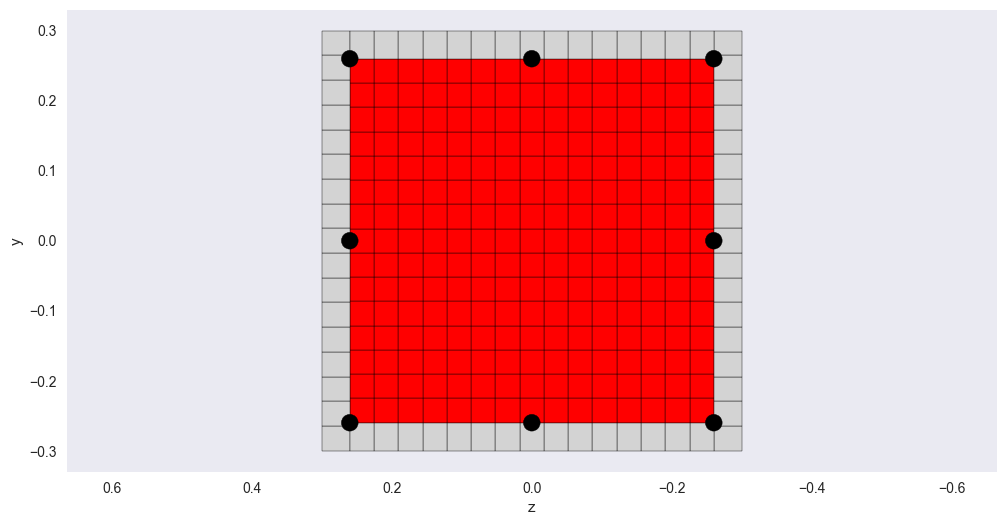

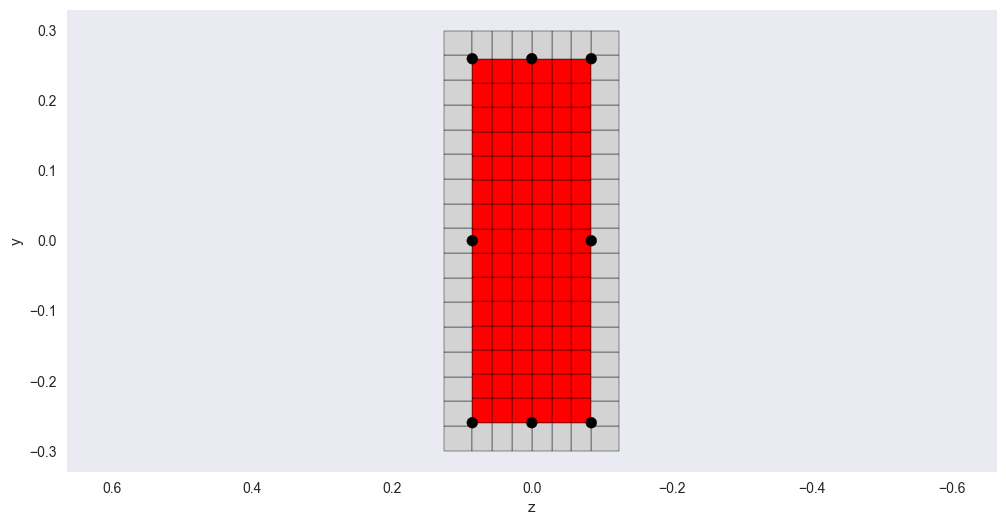

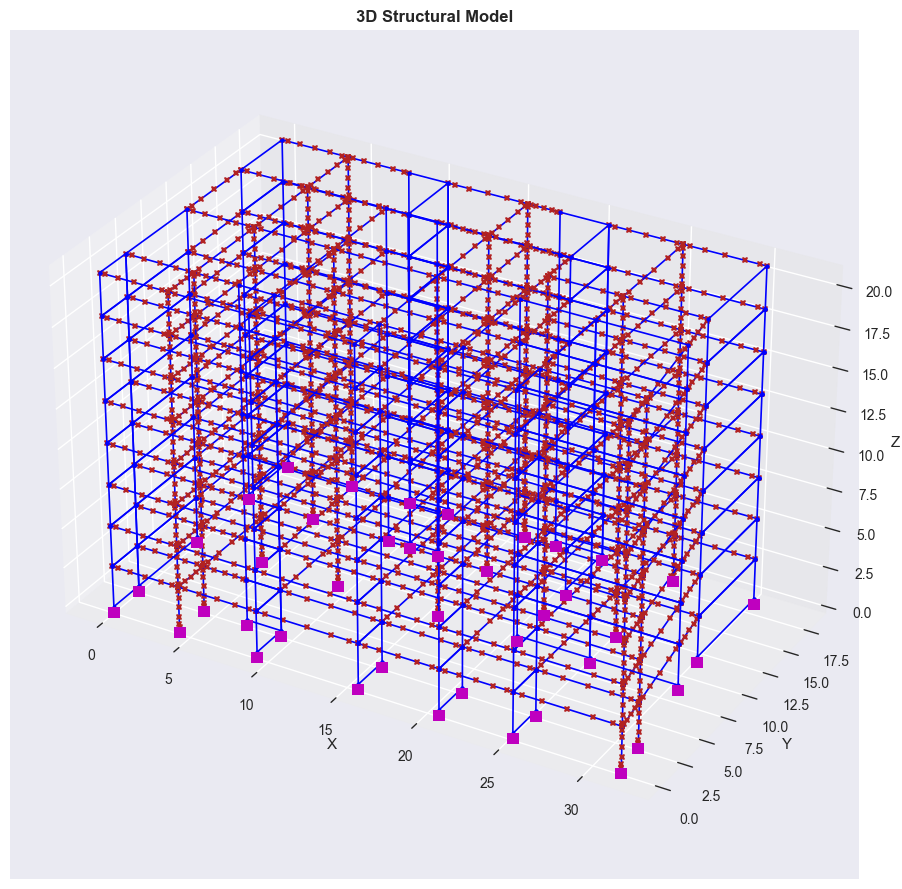

In [33]:
# -------------------------------
# 6.1 Model Initialization
# -------------------------------
ops.wipe()  # Clear any existing model

# Create basic 3D model with 6 degrees of freedom per node:
# UX, UY, UZ (translations), RX, RY, RZ (rotations)
ops.model('basic', '-ndm', 3, '-ndf', 6)

# Rigid diaphragm configuration (enabled/disabled)
rigid_diaphragm = True  # Enable to model rigid diaphragm behavior

# -------------------------------
# 6.2 Material Definitions
# -------------------------------

# Shear material for walls (elastic)
ops.uniaxialMaterial('Elastic', 3, G)  # G: Shear modulus (Pa)

# Confined concrete (column cores)
ops.uniaxialMaterial('Concrete02', 4,
    fpc1,    # Peak compressive strength (Pa)
    epsc01,  # Strain at peak strength
    fpcu1,   # Ultimate compressive strength (Pa)
    epsU1,   # Strain at ultimate strength
    lambda1, # Tension parameter
    ft1,     # Tensile strength (Pa)
    Ets      # Tension softening slope
)

# Unconfined concrete (cover)
ops.uniaxialMaterial('Concrete02', 5,
    fpc2,    # Peak compressive strength (Pa)
    epsc02,  # Strain at peak strength
    fpcu2,   # Ultimate compressive strength (Pa)
    epsU2,   # Strain at ultimate strength
    lambda1, # Tension parameter (same as confined)
    ft2,     # Tensile strength (Pa)
    Ets      # Tension softening slope (same as confined)
)

# Reinforcing steel (longitudinal and transverse bars)
ops.uniaxialMaterial('Steel02', 6,
    fy,      # Yield strength (Pa)
    Es,      # Elastic modulus (Pa)
    0.01,    # Strain hardening ratio
    18,      # Transition parameter
    0.925,   # Stress parameter
    0.15     # Tolerance parameter
)

# -------------------------------
# 6.3 Section Creation
# -------------------------------
# Create section objects for columns and beams
columns = [RectangularSection(col[0], col[1]) for col in column_sections]
beams = [RectangularSection(beam[0], beam[1]) for beam in beam_sections]

structure_model = StructureModel(num_columns, num_beams, columns, beams, G, cover)
structure_model.create_structure()

# -------------------------------
# 6.4 Node Creation
# -------------------------------
for node in nodes:
    ops.node(int(node[0]),  # Node tag
             node[1],       # X coordinate (m)
             node[2],       # Y coordinate (m)
             node[3])       # Z coordinate (m)

# -------------------------------
# 6.5 Rigid Diaphragms
# -------------------------------
if rigid_diaphragm:
    diaphragm_dir = 3  # Axis perpendicular to diaphragm plane (Z)

    for diaphragm in diaphragms:
        # Create master node for diaphragm
        ops.node(int(diaphragm[0]), diaphragm[1], diaphragm[2], diaphragm[3])

        # Constrain degrees of freedom (only allows XY translation)
        ops.fix(int(diaphragm[0]), 0, 0, 1, 1, 1, 0)

        # Identify nodes at the same level
        nodes_at_level = [int(node[0]) for node in nodes if node[3] == diaphragm[3]]

        # Create rigid diaphragm constraint
        ops.rigidDiaphragm(diaphragm_dir,
                          int(diaphragm[0]),  # Master node
                          *nodes_at_level)  # Slave nodes

# -------------------------------
# 6.6 Base Constraints
# -------------------------------
ops.fixZ(0.0,        # Elevation Z=0
         1, 1, 1,    # Constrain translations UX, UY, UZ
         1, 1, 1,    # Constrain rotations RX, RY, RZ
         '-tol', 1e-6)  # Tolerance for node identification

# -------------------------------
# 6.7 Geometric Transformations
# -------------------------------
# PDelta: Considers nonlinear geometric effects
ops.geomTransf('PDelta', 1, 1, 0, 0)  # For columns

# Linear: Standard linear transformation
ops.geomTransf('Linear', 2, 1, -1, 0)  # For beams

# -------------------------------
# 6.8 Element Integration
# -------------------------------
num_int_points = 7  # Gauss-Lobatto integration points

# Columns
for i in range(num_columns):
    ops.beamIntegration('Lobatto',
                       i + 1,          # Integration tag
                       i + 1,          # Section tag
                       num_int_points)  # Number of points

# Beams
for i in range(num_beams):
    ops.beamIntegration('Lobatto',
                       i + 1 + num_columns,  # Integration tag
                       i + 1 + num_columns,  # Section tag
                       num_int_points)

# -------------------------------
# 6.9 Element Creation
# -------------------------------
for elem in elements:
    elem_type = 'forceBeamColumn'  # Element type for beams/columns

    # Columns (type 1)
    if int(elem[5]) == 1:
        column_area = elem[3] * elem[4]  # Cross-sectional area
        ops.element(elem_type,
                   int(elem[0]),    # Element tag
                   int(elem[1]),    # Node I
                   int(elem[2]),    # Node J
                   1,               # Transformation (PDelta)
                   int(elem[6]),    # Integration tag
                   '-mass',
                   rho * column_area * m**2)  # Distributed mass

    # Beams (type 2)
    elif int(elem[5]) == 2:
        beam_area = elem[3] * elem[4]  # Cross-sectional area
        ops.element(elem_type,
                   int(elem[0]),
                   int(elem[1]),
                   int(elem[2]),
                   2,               # Transformation (Linear)
                   int(elem[6]),
                   '-mass',
                   rho * beam_area * m**2)

    # X-direction walls (type 3)
    elif int(elem[5]) == 3:
        length = abs(nodes[int(elem[1])][1] - nodes[int(elem[2])][1])
        wall_x = WallSection(length, elem[6])  # Create wall object

        # Get properties for MVLEM
        nf_x, thk_x, w_list_x, rho_x, conc_x, steel_x = wall_x.wall_properties()

        ops.element('MVLEM_3D',
                   int(elem[0]),    # Element tag
                   int(elem[1]),    # Node I
                   int(elem[2]),    # Node J
                   int(elem[3]),    # Node K
                   int(elem[4]),    # Node L
                   nf_x,            # Number of fibers
                   '-thick', *thk_x,       # Thicknesses
                   '-width', *w_list_x,    # Widths
                   '-rho', *rho_x,         # Reinforcement ratios
                   '-matConcrete', *conc_x, # Concrete material
                   '-matSteel', *steel_x,  # Steel material
                   '-matShear', 3,         # Shear material
                   '-Poisson', 0.2,        # Poisson's ratio
                   '-Density', rho)        # Density

    # Y-direction walls (type 4)
    elif int(elem[5]) == 4:
        length = abs(nodes[int(elem[1])][2] - nodes[int(elem[2])][2])
        wall_y = WallSection(length, elem[6])

        nf_y, thk_y, w_list_y, rho_y, conc_y, steel_y = wall_y.wall_properties()

        ops.element('MVLEM_3D',
                   int(elem[0]),
                   int(elem[1]),
                   int(elem[2]),
                   int(elem[3]),
                   int(elem[4]),
                   nf_y,
                   '-thick', *thk_y,
                   '-width', *w_list_y,
                   '-rho', *rho_y,
                   '-matConcrete', *conc_y,
                   '-matSteel', *steel_y,
                   '-matShear', 3,
                   '-Poisson', 0.2,
                   '-Density', rho)

# -------------------------------
# 6.10 Model Visualization
# -------------------------------
opsv.plot_model(node_labels=0, element_labels=0, local_axes=False, fig_wi_he=(40, 28))
plt.title("3D Structural Model")
plt.show()

## 7. Modal and Gravity Analysis

This section performs two fundamental analyses:
1. **Modal Analysis**: Computes natural frequencies and vibration modes  
2. **Gravity Analysis**: Applies permanent loads to obtain the initial equilibrium state  

**Key formulas**:
- Natural period: $T_i = \frac{2\pi}{\sqrt{\lambda_i}}$  
- Seismic weight: $W_{seismic} = (1.0 \cdot w_{dead} + 0.25 \cdot w_{live}) \cdot A_{floor}$  


🔹 Natural Vibration Periods:
Mode 1: T = 0.335 sec
Mode 2: T = 0.297 sec
Mode 3: T = 0.272 sec
Mode 4: T = 0.086 sec
Mode 5: T = 0.074 sec
Mode 6: T = 0.066 sec
Mode 7: T = 0.045 sec
Mode 8: T = 0.043 sec
Mode 9: T = 0.042 sec
Mode 10: T = 0.040 sec
Mode 11: T = 0.040 sec
Mode 12: T = 0.039 sec
Mode 13: T = 0.039 sec
Mode 14: T = 0.038 sec
Mode 15: T = 0.038 sec
Mode 16: T = 0.036 sec
Mode 17: T = 0.036 sec
Mode 18: T = 0.035 sec
Mode 19: T = 0.034 sec
Mode 20: T = 0.034 sec
Mode 21: T = 0.033 sec
Mode 22: T = 0.033 sec
Mode 23: T = 0.032 sec
Mode 24: T = 0.031 sec


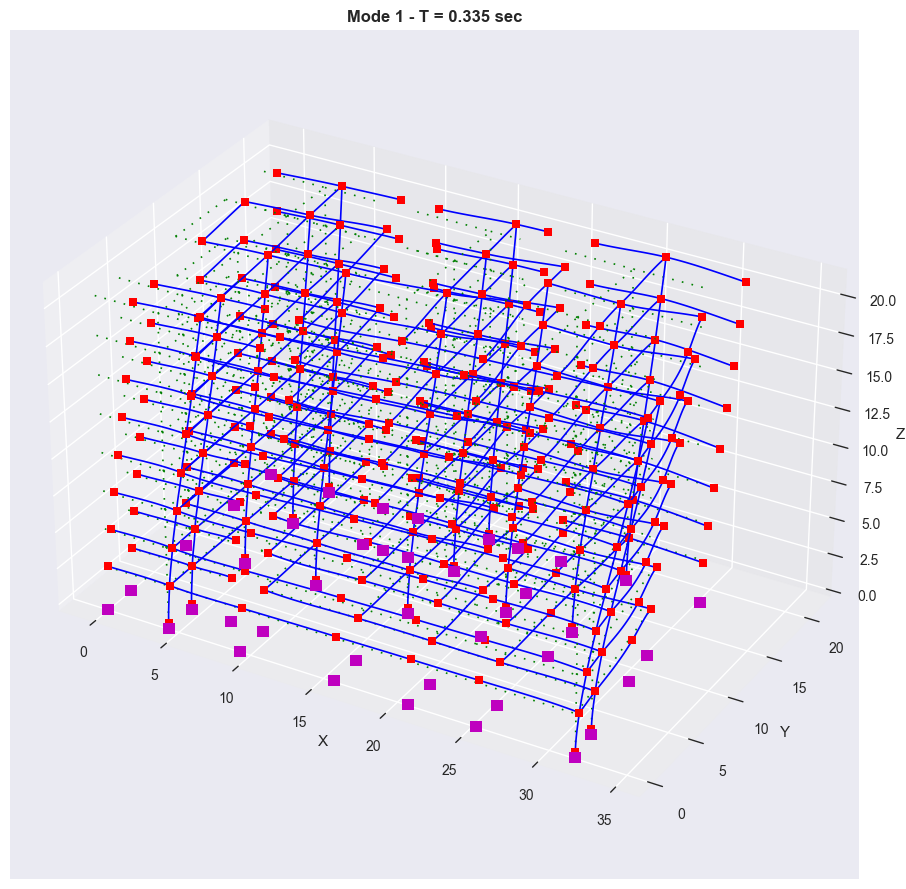

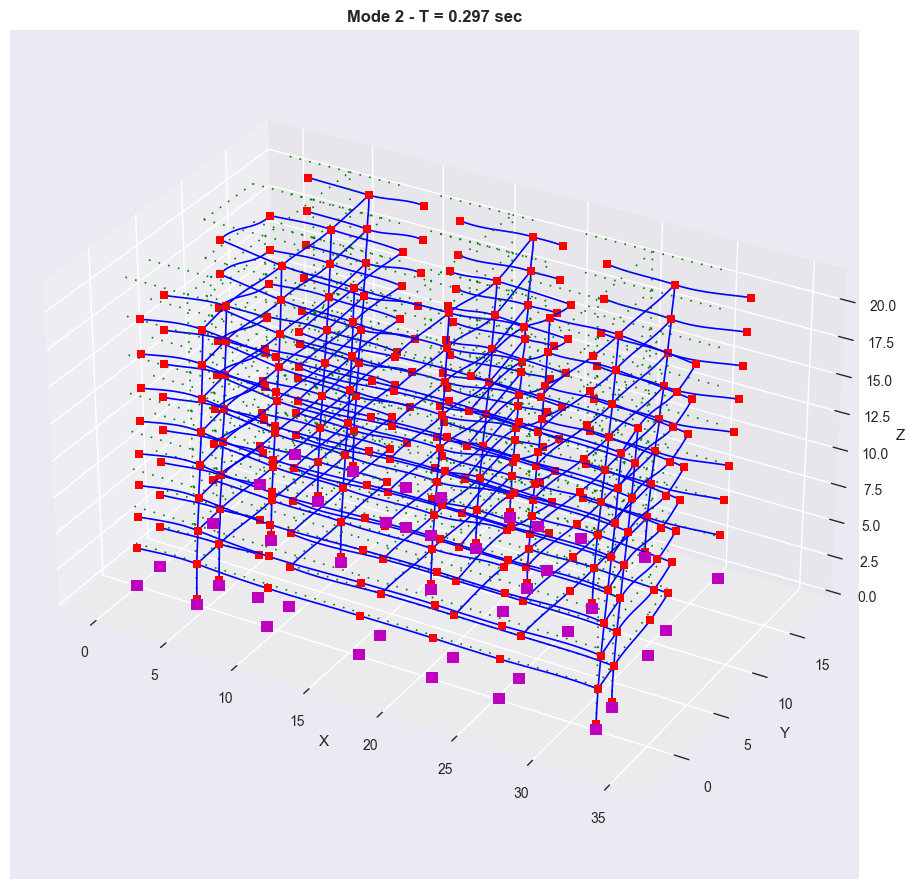

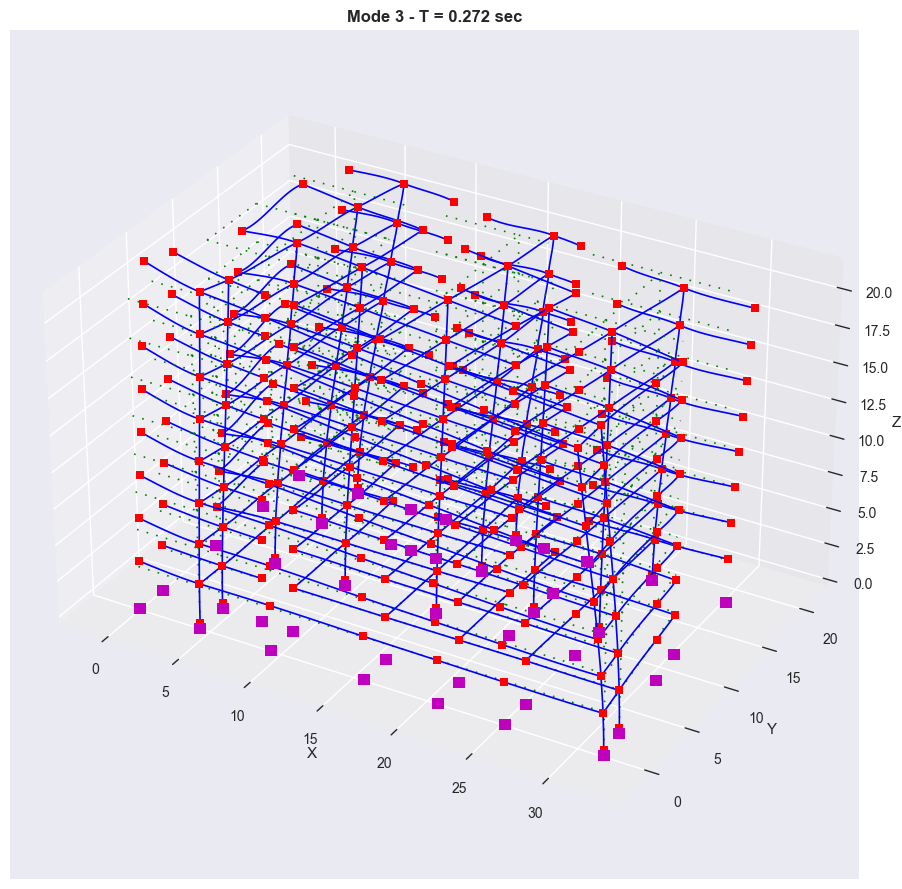

0

In [34]:
# -------------------------------
# 7.1 Load Definitions
# -------------------------------

# Uniform loads (kg/m²)
wLive = 250 * kg/m**2      # Live load
wSlab = 300 * kg/m**2      # Slab self-weight
wFinish = 100 * kg/m**2    # Floor finishes  
wPartition = 150 * kg/m**2 # Partition walls

# Load combination (100% dead + 25% live)
wTotal = 1.0*(wSlab + wFinish + wPartition) + 0.25*wLive

# Total load per floor (N)
FloorLoad = wTotal * floor_area * m**2

# -------------------------------
# 7.2 Mass Assignment  
# -------------------------------
for node in nodes:
    # Calculate nodal mass proportional to mass factor (node[4])
    nodal_mass = node[4] * FloorLoad / ((len(nodes)-len(base_nodes))/num_stories)

    # Assign mass in X and Y directions (negligible in Z)
    ops.mass(int(node[0]), nodal_mass, nodal_mass, 0.0)

# -------------------------------
# 7.3 Modal Analysis
# -------------------------------
num_modes = 3 * num_stories  # Number of modes to compute (3 per story)

# Compute eigenvalues
eigenvalues = ops.eigen(num_modes)

# Calculate natural periods  
periods = [2*np.pi/np.sqrt(eig) for eig in eigenvalues]

# Print results
print("\n🔹 Natural Vibration Periods:")
for i, T in enumerate(periods, 1):
    print(f"Mode {i}: T = {T:.3f} sec")

# Mode shape visualization
for i in range(3):
    opsv.plot_mode_shape(i+1, fig_wi_he=(40, 28))
    plt.title(f'Mode {i+1} - T = {periods[i]:.3f} sec')
plt.show()

# Configure load pattern
ops.timeSeries('Linear', 1)
ops.pattern('Plain', 1, 1)

# -------------------------------
# 7.4.1 Element Loads
# -------------------------------
for elem in elements:
    elem_type = int(elem[5])

    # Columns (axial load)
    if elem_type == 1:
        Ac = elem[3] * elem[4]  # Cross-sectional area
        ops.eleLoad('-ele', int(elem[0]), '-type',
                   '-beamUniform', 0.0, 0.0, -rho*Ac*g)  # Wx, Wy, Wz

    # Beams (transverse load)
    elif elem_type == 2:
        Av = elem[3] * elem[4]
        ops.eleLoad('-ele', int(elem[0]), '-type',
                   '-beamUniform', -rho*Av*g, 0.0, 0.0)

    # X-direction walls
    elif elem_type == 3:
        L = abs(nodes[int(elem[1])][1] - nodes[int(elem[2])][1])
        t = elem[6]
        wall_load = 0.25 * story_height * L * t * rho * g

        # Apply to 4 wall nodes
        for n in [int(elem[i]) for i in range(1,5)]:
            ops.load(n, 0., 0., -wall_load, 0., 0., 0.)

    # Y-direction walls
    elif elem_type == 4:
        L = abs(nodes[int(elem[1])][2] - nodes[int(elem[2])][2])
        t = elem[6]
        wall_load = 0.25 * story_height * L * t * rho * g

        for n in [int(elem[i]) for i in range(1,5)]:
            ops.load(n, 0., 0., -wall_load, 0., 0., 0.)
    else:
        print("Error! Undefined element type")

# -------------------------------
# 7.4.2 Nodal Loads
# -------------------------------
for node in nodes:
    if float(node[3]) > 0:  # Only nodes above base
        nodal_load = node[4] * FloorLoad * g / ((len(nodes)-len(base_nodes))/num_stories)
        ops.load(int(node[0]), 0.0, 0.0, -nodal_load, 0.0, 0.0, 0.0)

# -------------------------------
# 7.5.1 Analysis Configuration
# -------------------------------
tolerance = 1.0e-8  # Convergence tolerance

# Configuration for rigid diaphragms
constraintsType = "Transformation" if rigid_diaphragm else "Plain"

ops.constraints(constraintsType)
ops.numberer('RCM')            # Optimal renumbering  
ops.system('BandGeneral')      # Solver
ops.test('EnergyIncr', tolerance, 6) # Convergence test
ops.algorithm('Newton')        # Newton-Raphson algorithm

# -------------------------------
# 7.5.2 Gradual Load Application
# -------------------------------
num_steps = 10  # Number of load steps
load_increment = 1.0 / num_steps  # Initial load increment
ops.integrator('LoadControl', load_increment)
ops.analysis('Static')
ops.analyze(num_steps)  # Apply gravity loads

## 8. Incremental Dynamic Analysis (IDA)

This module performs Incremental Dynamic Analysis (IDA) on the building model using a selected ground motion record.

**Full process:**
1. Setup of the dynamic analysis parameters  
2. Definition of Rayleigh damping  
3. Preprocessing of the seismic record  
4. Execution of dynamic analyses at increasing intensity levels (scaling the record)  
5. Implementation of strategies for non-convergence recovery  
6. Extraction of peak response values (e.g., drift, base shear) for each intensity level  

#### **Rayleigh Damping**
Formula: $\xi = \alpha_M M + \beta_K K$

Where:
- $\alpha_M = \xi \frac{2\omega_i\omega_j}{\omega_i + \omega_j}$
- $\beta_K = \xi \frac{2}{\omega_i + \omega_j}$

In [ ]:
# IDA Analysis Configuration
ops.loadConst('-time', 0.0)
ops.wipeAnalysis()

print("\n🔥 INITIATING NONLINEAR DYNAMIC ANALYSIS (IDA) 🔥")
print("==============================================")

# Seismic analysis parameters
GMdirection = 1  # Direction of ground motion (1=X, 2=Y)
DtAnalysis = 0.02  # Analysis time step (sec)
TmaxAnalysis = 30.0  # Maximum analysis duration (sec)

# IDA scaling parameters (in g units)
IM_min = 0.1  # Minimum intensity measure (g)
IM_max = 8.0   # Maximum intensity measure (g)
IM_step = 0.1  # Intensity increment
GMfactors = np.arange(IM_min, IM_max + IM_step, IM_step)

# Ground motion file processing
inFile = "elCentro.AT2"  # PEER format ground motion
outFile = "elCentro.g3"  # Processed OpenSees format
dt, npts = ReadRecord(inFile, outFile)

# IDA analysis loop
for i, GMfact in enumerate(GMfactors):
    print(f"\n⚡ Running IDA with scale factor: {GMfact:.1f} ({i+1}/{len(GMfactors)})")
    
    # Reset analysis conditions
    ops.wipeAnalysis()
    ops.loadConst('-time', 0.0)

    # Equation system configuration
    ops.constraints("Transformation")
    ops.numberer("RCM")  # Reverse Cuthill-McKee ordering
    ops.system("BandGeneral")  # Banded general solver

    # Convergence test parameters
    TolDynamic = 1e-6  # Energy tolerance
    maxNumIterDynamic = 50  # Maximum iterations
    printFlagDynamic = 0  # No printing
    ops.test("EnergyIncr", TolDynamic, maxNumIterDynamic, printFlagDynamic)

    # Solution algorithms with fallback options
    algorithms = [
        {"name": "ModifiedNewton", "args": None, "desc": "Modified Newton (efficient)"},
        {"name": "Newton", "args": "-initial", "desc": "Newton with initial tangent"},
        {"name": "Broyden", "args": 8, "desc": "Broyden (8 iterations)"},
        {"name": "NewtonLineSearch", "args": "0.8", "desc": "Newton with line search (0.8)"},
        {"name": "KrylovNewton", "args": None, "desc": "Krylov-Newton (for large systems)"}
    ]

    current_algorithm_idx = 0
    current_algo = algorithms[current_algorithm_idx]
    print(f"🔄 Initial algorithm: {current_algo['name']} - {current_algo['desc']}")
    ops.algorithm(current_algo["name"], current_algo["args"] if current_algo["args"] else "")

    # Time integration scheme
    ops.integrator("Newmark", 0.5, 0.25)  # Average acceleration method
    ops.analysis("Transient")

    # Rayleigh damping (2% critical)
    xDamp = 0.02
    ops.rayleigh(xDamp*0.1, 0.0, 0.0, xDamp*0.9)  # Mass and stiffness proportional

    # Scaled ground motion excitation
    IDloadTag = i + 100  # Unique tag for each analysis
    GMfatt = g * GMfact  # Convert g to m/s²
    ops.timeSeries('Path', IDloadTag, '-dt', dt, '-filePath', outFile, '-factor', GMfatt)
    ops.pattern("UniformExcitation", IDloadTag, GMdirection, "-accel", IDloadTag)

    # Recorders for each scaling (without closeOnWrite)
    tagDiap = [int(Nd[0]) for Nd in diaphragms]  # Diaphragm master nodes
    recorder_file = f'Diaphragms_IDA_UX_{GMfact:.1f}.txt'
    recorder_tag = ops.recorder('Node', '-file', recorder_file, '-node', *tagDiap, '-dof', 1, 'disp')

    # Analysis monitoring
    start_time = time.time()
    Nsteps = int(TmaxAnalysis / DtAnalysis)
    controlTime = 0.0
    successful_steps = 0
    failed_steps = 0

    # Progress bar configuration
    with tqdm(total=TmaxAnalysis, desc="Analysis progress", unit="s", 
             bar_format="{l_bar}{bar}| {n:.1f}/{total_fmt} [{elapsed}<{remaining}]") as progress_bar:

        while controlTime < TmaxAnalysis:
            ok = ops.analyze(1, DtAnalysis)

            if ok == 0:
                successful_steps += 1
                controlTime = ops.getTime()
                progress_bar.update(DtAnalysis)
                
                # Return to primary algorithm if successful
                if current_algorithm_idx > 0:
                    current_algorithm_idx = 0
                    current_algo = algorithms[current_algorithm_idx]
                    ops.algorithm(current_algo["name"], current_algo["args"] if current_algo["args"] else "")
                    print(f"↩️ Reverting to primary algorithm: {current_algo['name']}")
            else:
                failed_steps += 1
                progress_bar.set_postfix_str(f"❌ Convergence failure (attempts: {failed_steps})")

                # Try next algorithm in sequence
                current_algorithm_idx += 1

                if current_algorithm_idx < len(algorithms):
                    current_algo = algorithms[current_algorithm_idx]
                    ops.algorithm(current_algo["name"], current_algo["args"] if current_algo["args"] else "")
                    print(f"🔄 Switching to algorithm: {current_algo['name']} - {current_algo['desc']}")
                else:
                    # If all algorithms fail, try reduced time step
                    reduced_dt = DtAnalysis / 2.0
                    progress_bar.write(f"⚠️ All algorithms failed. Trying reduced dt: {reduced_dt:.4f}s")

                    ok = ops.analyze(1, reduced_dt)
                    if ok == 0:
                        controlTime = ops.getTime()
                        successful_steps += 1
                        progress_bar.update(reduced_dt)
                        print(f"✅ Successful step with reduced dt (t={controlTime:.2f}s)")
                    else:
                        progress_bar.write("💥 Analysis cannot continue. Stopping...")
                        break

                    # Reset to primary algorithm
                    current_algorithm_idx = 0
                    current_algo = algorithms[current_algorithm_idx]
                    ops.algorithm(current_algo["name"], current_algo["args"] if current_algo["args"] else "")

    # Proper recorder cleanup using its tag
    ops.remove('recorder', recorder_tag)
    print(f"✔️ Recorder {recorder_tag} closed - File: {recorder_file}")

    # Analysis summary
    end_time = time.time()
    elapsed_time = end_time - start_time
    hours = int(elapsed_time // 3600)
    minutes = int((elapsed_time % 3600) // 60)
    seconds = int(elapsed_time % 60)

    print("\n📝 ANALYSIS SUMMARY")
    print("============================")
    print(f"Scale factor: {GMfact:.1f}")
    print(f"Simulated time: {controlTime:.2f}s of {TmaxAnalysis}s")
    print(f"Successful steps: {successful_steps}")
    print(f"Failed steps: {failed_steps}")
    print(f"Success rate: {successful_steps/(successful_steps+failed_steps)*100:.1f}%")
    print(f"Execution time: {hours}h {minutes}m {seconds}s\n")


🔥 INITIATING NONLINEAR DYNAMIC ANALYSIS (IDA) 🔥

⚡ Running IDA with scale factor: 6.4 (1/17)
🔄 Initial algorithm: ModifiedNewton - Modified Newton (efficient)


Analysis progress:   6%|▌         | 1.7/30.0 [00:34<11:52]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 311(dW: << 1.57235e-07, dW0: -0.000690059)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 1.72
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   6%|▌         | 1.7/30.0 [00:36<23:31]

🔄 Switching to algorithm: Newton - Newton with initial tangent
↩️ Reverting to primary algorithm: ModifiedNewton


Analysis progress:   6%|▌         | 1.7/30.0 [00:37<23:48]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 105(dW: << 6.51645, dW0: -23153.6)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 1.76
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   6%|▌         | 1.8/30.0 [00:42<33:15]

🔄 Switching to algorithm: Newton - Newton with initial tangent
↩️ Reverting to primary algorithm: ModifiedNewton


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 166(dW: << -0.0492164, dW0: 1310.93)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 1.8
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   6%|▌         | 1.8/30.0 [00:42<33:15]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 166(dW: << 233374, dW0: 2.61995e+06)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonRaphson::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 1.8
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   6%|▌         | 1.8/30.0 [00:43<33:15]

🔄 Switching to algorithm: Newton - Newton with initial tangent
🔄 Switching to algorithm: Broyden - Broyden (8 iterations)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 166(dW: << 0.00118309, dW0: 62.2777)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING Broyden::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 1.8
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   6%|▌         | 1.8/30.0 [00:44<33:15]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 166(dW: << -0.0206139, dW0: 31475.2)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonLineSearch::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 1.8
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   6%|▌         | 1.8/30.0 [00:44<33:15]

🔄 Switching to algorithm: NewtonLineSearch - Newton with line search (0.8)
🔄 Switching to algorithm: KrylovNewton - Krylov-Newton (for large systems)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 166(dW: << 0.00232216, dW0: 3.30788e+08)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING AcceleratedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 1.8
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   6%|▌         | 1.8/30.0 [00:45<33:15]

⚠️ All algorithms failed. Trying reduced dt: 0.0100s


after: 50 iterations
 current EnergyIncr: 0.345427 (max: 1e-06) 	Norm deltaX: 8.0978e-05, Norm deltaR: 9893.12
AcceleratedNewton::solveCurrentStep() -The ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 1.79
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   6%|▌         | 1.8/30.0 [00:48<12:44]


💥 Analysis cannot continue. Stopping...
✔️ Recorder 0 closed - File: Diaphragms_IDA_UX_6.4.txt

📝 ANALYSIS SUMMARY
Scale factor: 6.4
Simulated time: 1.78s of 30.0s
Successful steps: 89
Failed steps: 7
Success rate: 92.7%
Execution time: 0h 0m 48s


⚡ Running IDA with scale factor: 6.5 (2/17)
🔄 Initial algorithm: ModifiedNewton - Modified Newton (efficient)


Analysis progress:   0%|          | 0.0/30.0 [00:00<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 166(dW: << 50.2738, dW0: 1300.47)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   0%|          | 0.0/30.0 [00:00<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 166(dW: << 0.000934997, dW0: -9.60402e+08)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonRaphson::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   0

🔄 Switching to algorithm: Newton - Newton with initial tangent
🔄 Switching to algorithm: Broyden - Broyden (8 iterations)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 165(dW: << 0.000340034, dW0: 9.95598e+06)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 166(dW: << -0.156231, dW0: 8.93957e+08)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 227(dW: << -40.2309, dW0: 6543.82)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING Broyden::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   0%|          | 0.0/30.0 [00:02<?]

🔄 Switching to algorithm: NewtonLineSearch - Newton with line search (0.8)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 165(dW: << 0.000306863, dW0: -2.05885e+07)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 166(dW: << 26.279, dW0: -4.63939e+08)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonLineSearch::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   0%|          | 0.0/30.0 [00:03<1:30:35]

🔄 Switching to algorithm: KrylovNewton - Krylov-Newton (for large systems)
↩️ Reverting to primary algorithm: ModifiedNewton


Analysis progress:   4%|▍         | 1.2/30.0 [00:27<10:35]  WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 396.118 (max: 1e-06) 	Norm deltaX: 0.00415061, Norm deltaR: 621503
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 1.24
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   4%|▍         | 1.2/30.0 [00:29<10:35]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 2.47088e-05 (max: 1e-06) 	Norm deltaX: 3.54607e-07, Norm deltaR: 184.593
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 1.24
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   4%|▍         | 1.2/30.0 [00:34<10:35]

🔄 Switching to algorithm: Newton - Newton with initial tangent
🔄 Switching to algorithm: Broyden - Broyden (8 iterations)


Analysis progress:   4%|▍         | 1.2/30.0 [00:34<1:00:18]

↩️ Reverting to primary algorithm: ModifiedNewton


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 6(dW: << 5.96068e-07, dW0: -0.0302165)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 1.26
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   4%|▍         | 1.3/30.0 [00:37<1:03:27]

🔄 Switching to algorithm: Newton - Newton with initial tangent
↩️ Reverting to primary algorithm: ModifiedNewton


Analysis progress:   4%|▍         | 1.3/30.0 [00:38<51:55]  WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 288(dW: << 0.0701941, dW0: 5516.19)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 1.3
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   4%|▍         | 1.3/30.0 [00:39<51:55]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 286(dW: << 0.00025838, dW0: 258547)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 287(dW: << 8.82821, dW0: 8.5971e+08)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 288(dW: << 211.803, dW0: 5.61761e+08)
Domain::update - doma

🔄 Switching to algorithm: Newton - Newton with initial tangent


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 56(dW: << 0.000203595, dW0: -3098.06)


🔄 Switching to algorithm: Broyden - Broyden (8 iterations)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 287(dW: << -0.224622, dW0: 1.90233e+10)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 288(dW: << 0.175072, dW0: -9.30278e+09)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING Broyden::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 1.3
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   4%|▍         | 1.3/30.0 [00:42<51:55]

🔄 Switching to algorithm: NewtonLineSearch - Newton with line search (0.8)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 288(dW: << 7.37189, dW0: 1.90888e+10)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonLineSearch::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 1.3
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   4%|▍         | 1.3/30.0 [00:44<1:14:48]

🔄 Switching to algorithm: KrylovNewton - Krylov-Newton (for large systems)
↩️ Reverting to primary algorithm: ModifiedNewton


Analysis progress:   6%|▌         | 1.7/30.0 [00:54<16:22]  WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 389(dW: << -0.00855044, dW0: 119113)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 1.7
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   6%|▌         | 1.7/30.0 [00:55<16:22]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 0.000399056 (max: 1e-06) 	Norm deltaX: 8.38786e-07, Norm deltaR: 1941.58
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 1.7
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   6%|▌         | 1.7/30.0 [01:00<16:22]

🔄 Switching to algorithm: Newton - Newton with initial tangent
🔄 Switching to algorithm: Broyden - Broyden (8 iterations)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 390(dW: << -0.000329719, dW0: 183546)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 418(dW: << -42.8807, dW0: 124102)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 479(dW: << 0.0043135, dW0: -44855.4)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING Broyden::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 1.7
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   6%|▌         | 1.7/30.0 [01:03<16:22]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 52(dW: << 1.54183e-05, dW0: 17733.5)


🔄 Switching to algorithm: NewtonLineSearch - Newton with line search (0.8)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 113(dW: << -0.000538709, dW0: 83592.9)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 235(dW: << 765435, dW0: 1617.04)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 296(dW: << 857777, dW0: 10761.2)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 390(dW: << 23.648, dW0: 1.66126e+08)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 418(dW: << 0.00367381, dW0: -221638)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonLineSearch::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 1.7
OpenSees > analyze failed, returned: -3 error flag

🔄 Switching to algorithm: KrylovNewton - Krylov-Newton (for large systems)
↩️ Reverting to primary algorithm: ModifiedNewton


Analysis progress:   6%|▌         | 1.7/30.0 [01:07<1:12:34]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 19(dW: << 3.01087e-05, dW0: -0.0150137)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 1.74
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   6%|▌         | 1.7/30.0 [01:08<1:12:34]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 9.70087e-06 (max: 1e-06) 	Norm deltaX: 1.2536e-07, Norm deltaR: 236.349
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 1.74
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   6%|▌         | 1.7/30.0 [01:14<1:12:34]

🔄 Switching to algorithm: Newton - Newton with initial tangent
🔄 Switching to algorithm: Broyden - Broyden (8 iterations)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 324(dW: << 25.5921, dW0: 1.72307)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING Broyden::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 1.74
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   6%|▌         | 1.7/30.0 [01:18<2:08:50]

🔄 Switching to algorithm: NewtonLineSearch - Newton with line search (0.8)
↩️ Reverting to primary algorithm: ModifiedNewton


Analysis progress:   6%|▌         | 1.8/30.0 [01:19<1:38:17]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 199(dW: << 314996, dW0: 230562)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 260(dW: << 2.19142e+06, dW0: 813665)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 1.78
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   6%|▌         | 1.8/30.0 [01:21<1:38:17]

🔄 Switching to algorithm: Newton - Newton with initial tangent


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 321(dW: << 0.000308058, dW0: 1.16738e+08)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonRaphson::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 1.78
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   6%|▌         | 1.8/30.0 [01:23<1:38:17]

🔄 Switching to algorithm: Broyden - Broyden (8 iterations)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 260(dW: << 1.37314e+06, dW0: 8.44573e+06)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 321(dW: << 0.000291107, dW0: 2.85478e+08)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING Broyden::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 1.78
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   6%|▌         | 1.8/30.0 [01:23<1:38:17]WARNING - ForceBeamColumn3d::update - failed to get compatible 

🔄 Switching to algorithm: NewtonLineSearch - Newton with line search (0.8)


element forces & deformations for element: 237(dW: << 0.00521254, dW0: 2.74617e+06)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonLineSearch::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 1.78
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   6%|▌         | 1.8/30.0 [01:26<1:38:17]

🔄 Switching to algorithm: KrylovNewton - Krylov-Newton (for large systems)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 260(dW: << 251489, dW0: 8.20573e+09)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 288(dW: << -0.00580118, dW0: -1.33366e+06)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING AcceleratedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 1.78
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   6%|▌         | 1.8/30.0 [01:27<1:38:17]

⚠️ All algorithms failed. Trying reduced dt: 0.0100s


Analysis progress:   6%|▌         | 1.8/30.0 [01:29<2:40:56]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 56(dW: << 0.0133185, dW0: 494.963)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 1.79
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   6%|▌         | 1.8/30.0 [01:29<2:40:56]

✅ Successful step with reduced dt (t=1.77s)
🔄 Switching to algorithm: Newton - Newton with initial tangent


Analysis progress:   6%|▌         | 1.8/30.0 [01:32<1:34:12]

↩️ Reverting to primary algorithm: ModifiedNewton


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 464(dW: << 493270, dW0: -120875)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 1.83
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   6%|▌         | 1.8/30.0 [01:33<1:34:12]

🔄 Switching to algorithm: Newton - Newton with initial tangent


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 53(dW: << 7.20491e-05, dW0: 10064.8)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 384(dW: << 5.07635, dW0: 259.865)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 461(dW: << 0.000960822, dW0: 955978)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 465(dW: << 0.000457991, dW0: 3.32674e+06)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonRaphson::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 1.83
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   6%|▌         | 1.8/30.0 [01:35<1:34:12]WARNING - ForceBeamColumn3d::update - failed to get compatible element force

🔄 Switching to algorithm: Broyden - Broyden (8 iterations)
🔄 Switching to algorithm: NewtonLineSearch - Newton with line search (0.8)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 465(dW: << 0.00107477, dW0: 54066.5)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonLineSearch::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 1.83
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   6%|▌         | 1.8/30.0 [01:39<1:34:12]

🔄 Switching to algorithm: KrylovNewton - Krylov-Newton (for large systems)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 403(dW: << 0.0472524, dW0: 1.12555e+09)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 464(dW: << -0.0155017, dW0: -2.6585e+07)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING AcceleratedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 1.83
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   6%|▌         | 1.8/30.0 [01:41<1:34:12]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 464(dW: << 1.81469, dW0: 575054)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING AcceleratedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the A

⚠️ All algorithms failed. Trying reduced dt: 0.0100s


-3 error flag
Analysis progress:   6%|▌         | 1.8/30.0 [01:42<26:31]  


💥 Analysis cannot continue. Stopping...
✔️ Recorder 1 closed - File: Diaphragms_IDA_UX_6.5.txt

📝 ANALYSIS SUMMARY
Scale factor: 6.5
Simulated time: 1.81s of 30.0s
Successful steps: 91
Failed steps: 29
Success rate: 75.8%
Execution time: 0h 1m 42s


⚡ Running IDA with scale factor: 6.6 (3/17)
🔄 Initial algorithm: ModifiedNewton - Modified Newton (efficient)


Analysis progress:   0%|          | 0.0/30.0 [00:00<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 463(dW: << 0.00989634, dW0: 4711.02)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   0%|          | 0.0/30.0 [00:01<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 52(dW: << -0.125635, dW0: -38160)


🔄 Switching to algorithm: Newton - Newton with initial tangent


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 384(dW: << 3.82405, dW0: 301.498)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 419(dW: << 0.00059471, dW0: 77031.9)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 465(dW: << 0.000357468, dW0: -520747)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonRaphson::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   0%|          | 0.0/30.0 [00:02<?]

🔄 Switching to algorithm: Broyden - Broyden (8 iterations)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 53(dW: << -0.000152811, dW0: 10851.7)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 419(dW: << -0.00277019, dW0: 295438)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 463(dW: << -2.78447, dW0: 7.06625e+06)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 464(dW: << 0.117769, dW0: 240341)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING Broyden::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   0%|          | 0.0/30.0 [00:05<?]

🔄 Switching to algorithm: NewtonLineSearch - Newton with line search (0.8)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 23(dW: << 0.0800208, dW0: -7852.87)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 464(dW: << 1.30975, dW0: 8.39426e+08)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonLineSearch::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   0%|          | 0.0/30.0 [00:06<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 464(dW: << 1.65928, dW0: 934991)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING AcceleratedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm faile

🔄 Switching to algorithm: KrylovNewton - Krylov-Newton (for large systems)
⚠️ All algorithms failed. Trying reduced dt: 0.0100s


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 403(dW: << 8.26602e-06, dW0: -1.40642)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING AcceleratedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.01
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   0%|          | 0.0/30.0 [00:08<?]


💥 Analysis cannot continue. Stopping...
✔️ Recorder 2 closed - File: Diaphragms_IDA_UX_6.6.txt

📝 ANALYSIS SUMMARY
Scale factor: 6.6
Simulated time: 0.00s of 30.0s
Successful steps: 0
Failed steps: 5
Success rate: 0.0%
Execution time: 0h 0m 8s


⚡ Running IDA with scale factor: 6.7 (4/17)
🔄 Initial algorithm: ModifiedNewton - Modified Newton (efficient)


Analysis progress:   0%|          | 0.0/30.0 [00:00<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 463(dW: << 0.0250452, dW0: 3895.45)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 464(dW: << 1.24742e+06, dW0: -434053)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   0%|          | 0.0/30.0 [00:00<?]

🔄 Switching to algorithm: Newton - Newton with initial tangent


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 52(dW: << 0.0481132, dW0: -37856.6)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 384(dW: << 3.54476, dW0: 262.837)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 419(dW: << 0.000786827, dW0: -84967.2)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 461(dW: << 0.0100845, dW0: -5.03483e+06)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 463(dW: << 0.0206085, dW0: 9.90182e+07)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 464(dW: << 18427.5, dW0: 5.88818e+07)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 465(dW: << 0.000634957, dW0: -

🔄 Switching to algorithm: Broyden - Broyden (8 iterations)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 53(dW: << 7.36692e-05, dW0: 9176.5)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 419(dW: << -0.0247295, dW0: -641747)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 463(dW: << -7.74769e-05, dW0: 247409)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING Broyden::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   0%|          | 0.0/30.0 [00:05<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 464(dW: << 0.259394, dW0: 7.99221e+08)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain

🔄 Switching to algorithm: NewtonLineSearch - Newton with line search (0.8)
🔄 Switching to algorithm: KrylovNewton - Krylov-Newton (for large systems)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 464(dW: << 1.66182, dW0: 957752)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING AcceleratedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   0%|          | 0.0/30.0 [00:06<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 464(dW: << 0.00138739, dW0: 0.0222922)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING AcceleratedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.01


⚠️ All algorithms failed. Trying reduced dt: 0.0100s


OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   0%|          | 0.0/30.0 [00:08<?]


💥 Analysis cannot continue. Stopping...
✔️ Recorder 3 closed - File: Diaphragms_IDA_UX_6.7.txt

📝 ANALYSIS SUMMARY
Scale factor: 6.7
Simulated time: 0.00s of 30.0s
Successful steps: 0
Failed steps: 5
Success rate: 0.0%
Execution time: 0h 0m 8s


⚡ Running IDA with scale factor: 6.8 (5/17)
🔄 Initial algorithm: ModifiedNewton - Modified Newton (efficient)


Analysis progress:   0%|          | 0.0/30.0 [00:00<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 464(dW: << 0.252537, dW0: -448389)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   0%|          | 0.0/30.0 [00:01<?]

🔄 Switching to algorithm: Newton - Newton with initial tangent


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 384(dW: << 3.55045, dW0: 263.606)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 419(dW: << 0.00317566, dW0: -80714.2)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 463(dW: << 0.0239572, dW0: 9.93021e+07)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 464(dW: << 0.583294, dW0: 5.9529e+07)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonRaphson::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   0%|          | 0.0/30.0 [00:02<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & de

🔄 Switching to algorithm: Broyden - Broyden (8 iterations)
🔄 Switching to algorithm: NewtonLineSearch - Newton with line search (0.8)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 14(dW: << 3.37623, dW0: 550.915)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 175(dW: << 0.023782, dW0: -1.0297e+06)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 236(dW: << 0.000631532, dW0: -4.61482e+07)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 358(dW: << -0.432699, dW0: -4.95355e+06)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 402(dW: << 230583, dW0: 1.91484e+10)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 416(dW: << 0.00391877, dW0: -7.54257e+06)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 419(dW: << -0.0243827, 

🔄 Switching to algorithm: KrylovNewton - Krylov-Newton (for large systems)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 24(dW: << 0.000238734, dW0: 2.95203e+08)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 320(dW: << 0.0259605, dW0: -29441)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 402(dW: << 0.119219, dW0: 3.40775e+10)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 419(dW: << -3.61054e-06, dW0: 9.59502e+08)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 480(dW: << 0.0140102, dW0: 2.56268e+08)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING AcceleratedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, re

⚠️ All algorithms failed. Trying reduced dt: 0.0100s


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 464(dW: << 1.84224, dW0: 2.29811e+06)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING AcceleratedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.01
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   0%|          | 0.0/30.0 [00:14<?]


💥 Analysis cannot continue. Stopping...
✔️ Recorder 4 closed - File: Diaphragms_IDA_UX_6.8.txt

📝 ANALYSIS SUMMARY
Scale factor: 6.8
Simulated time: 0.00s of 30.0s
Successful steps: 0
Failed steps: 5
Success rate: 0.0%
Execution time: 0h 0m 14s


⚡ Running IDA with scale factor: 6.9 (6/17)
🔄 Initial algorithm: ModifiedNewton - Modified Newton (efficient)


Analysis progress:   0%|          | 0.0/30.0 [00:00<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 463(dW: << 0.00953985, dW0: 4518.78)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 464(dW: << 3.76387, dW0: -463588)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   0%|          | 0.0/30.0 [00:01<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 52(dW: << -0.0147954, dW0: -35662.9)


🔄 Switching to algorithm: Newton - Newton with initial tangent


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 384(dW: << 3.55638, dW0: 264.408)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 461(dW: << 0.00104606, dW0: -3.8109e+06)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonRaphson::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   0%|          | 0.0/30.0 [00:02<?]

🔄 Switching to algorithm: Broyden - Broyden (8 iterations)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 24(dW: << 529548, dW0: 37810.7)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 53(dW: << 2.20357e-05, dW0: 9287.1)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 419(dW: << 0.00826865, dW0: -188775)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 463(dW: << 0.00637747, dW0: 247824)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 464(dW: << -0.0565025, dW0: 194308)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING Broyden::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Analysis 

🔄 Switching to algorithm: NewtonLineSearch - Newton with line search (0.8)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 183(dW: << 0.00934137, dW0: 6262.86)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 228(dW: << -0.673362, dW0: -328359)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 310(dW: << 1.52972e+08, dW0: 1.25196e+10)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 465(dW: << 0.0271693, dW0: 34739)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonLineSearch::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   0%|          | 0.0/30.0 [00:09<?]

🔄 Switching to algorithm: KrylovNewton - Krylov-Newton (for large systems)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 188(dW: << 14.7367, dW0: 2.92251e+08)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 249(dW: << 840212, dW0: 4.80906e+10)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 255(dW: << 0.00372914, dW0: 5.66047e+07)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 403(dW: << 4.05719, dW0: 1.43636e+09)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING AcceleratedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   0%|          | 0.0/30.0 [00:12<?]

⚠️ All algorithms failed. Trying reduced dt: 0.0100s


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 464(dW: << 1.84524, dW0: 2.29581e+06)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING AcceleratedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.01
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   0%|          | 0.0/30.0 [00:13<?]


💥 Analysis cannot continue. Stopping...
✔️ Recorder 5 closed - File: Diaphragms_IDA_UX_6.9.txt

📝 ANALYSIS SUMMARY
Scale factor: 6.9
Simulated time: 0.00s of 30.0s
Successful steps: 0
Failed steps: 5
Success rate: 0.0%
Execution time: 0h 0m 13s


⚡ Running IDA with scale factor: 7.0 (7/17)
🔄 Initial algorithm: ModifiedNewton - Modified Newton (efficient)


Analysis progress:   0%|          | 0.0/30.0 [00:00<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 463(dW: << 0.0184476, dW0: 4588.33)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 464(dW: << 0.0326342, dW0: -479851)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   0%|          | 0.0/30.0 [00:01<?]

🔄 Switching to algorithm: Newton - Newton with initial tangent


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 52(dW: << 0.0665333, dW0: -36038.5)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 384(dW: << 3.56247, dW0: 265.233)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 461(dW: << 0.00115806, dW0: -3.37688e+06)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 463(dW: << -0.000707053, dW0: 9.97607e+07)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 464(dW: << 0.00680262, dW0: 6.08508e+07)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonRaphson::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned

🔄 Switching to algorithm: Broyden - Broyden (8 iterations)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 464(dW: << -0.0117982, dW0: 291369)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 465(dW: << 0.000372326, dW0: -60462.4)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING Broyden::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   0%|          | 0.0/30.0 [00:05<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 464(dW: << -0.143605, dW0: 2.20634e+08)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonLineSearch::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed 

🔄 Switching to algorithm: NewtonLineSearch - Newton with line search (0.8)
🔄 Switching to algorithm: KrylovNewton - Krylov-Newton (for large systems)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 464(dW: << 1.66968, dW0: 1.05395e+06)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING AcceleratedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   0%|          | 0.0/30.0 [00:06<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 403(dW: << 0.00292081, dW0: 9.24726)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING AcceleratedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.01
OpenSees > analyze failed, returned: 

⚠️ All algorithms failed. Trying reduced dt: 0.0100s


-3 error flag
Analysis progress:   0%|          | 0.0/30.0 [00:07<?]


💥 Analysis cannot continue. Stopping...
✔️ Recorder 6 closed - File: Diaphragms_IDA_UX_7.0.txt

📝 ANALYSIS SUMMARY
Scale factor: 7.0
Simulated time: 0.00s of 30.0s
Successful steps: 0
Failed steps: 5
Success rate: 0.0%
Execution time: 0h 0m 7s


⚡ Running IDA with scale factor: 7.1 (8/17)
🔄 Initial algorithm: ModifiedNewton - Modified Newton (efficient)


Analysis progress:   0%|          | 0.0/30.0 [00:00<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 463(dW: << 0.0636455, dW0: 45956.8)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   0%|          | 0.0/30.0 [00:01<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 175(dW: << 0.00129585, dW0: 4977.44)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 236(dW: << 1.26886e-07, dW0: 2330.98)


🔄 Switching to algorithm: Newton - Newton with initial tangent


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 297(dW: << 1.01253e-05, dW0: 41548)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 419(dW: << 8.49414e-05, dW0: -577804)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 464(dW: << 105.255, dW0: 8.26579e+08)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 465(dW: << 0.00115051, dW0: -1.6245e+06)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonRaphson::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   0%|          | 0.0/30.0 [00:03<?]

🔄 Switching to algorithm: Broyden - Broyden (8 iterations)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 24(dW: << 443891, dW0: 37798.4)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 419(dW: << 0.552763, dW0: -622213)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 464(dW: << 0.136391, dW0: 194117)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING Broyden::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   0%|          | 0.0/30.0 [00:06<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 464(dW: << 493286, dW0: 8.05667e+08)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING New

🔄 Switching to algorithm: NewtonLineSearch - Newton with line search (0.8)
🔄 Switching to algorithm: KrylovNewton - Krylov-Newton (for large systems)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 464(dW: << 1.67238, dW0: 1.09934e+06)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING AcceleratedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   0%|          | 0.0/30.0 [00:08<?]

⚠️ All algorithms failed. Trying reduced dt: 0.0100s


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 403(dW: << 0.500725, dW0: 0.409215)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING AcceleratedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.01
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   0%|          | 0.0/30.0 [00:09<?]


💥 Analysis cannot continue. Stopping...
✔️ Recorder 7 closed - File: Diaphragms_IDA_UX_7.1.txt

📝 ANALYSIS SUMMARY
Scale factor: 7.1
Simulated time: 0.00s of 30.0s
Successful steps: 0
Failed steps: 5
Success rate: 0.0%
Execution time: 0h 0m 9s


⚡ Running IDA with scale factor: 7.2 (9/17)
🔄 Initial algorithm: ModifiedNewton - Modified Newton (efficient)


Analysis progress:   0%|          | 0.0/30.0 [00:00<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 463(dW: << 0.00464718, dW0: 4731.6)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 464(dW: << 0.17595, dW0: -515440)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   0%|          | 0.0/30.0 [00:01<?]

🔄 Switching to algorithm: Newton - Newton with initial tangent


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 52(dW: << 0.012925, dW0: -35145.9)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 384(dW: << 3.57532, dW0: 266.972)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 463(dW: << 0.0128359, dW0: 1.00112e+08)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 464(dW: << 0.0766224, dW0: 6.22286e+07)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 465(dW: << 0.00300301, dW0: -408201)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonRaphson::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error

🔄 Switching to algorithm: Broyden - Broyden (8 iterations)
🔄 Switching to algorithm: NewtonLineSearch - Newton with line search (0.8)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 249(dW: << 413573, dW0: 8.39324e+09)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 289(dW: << 8.61572e+09, dW0: 115214)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 465(dW: << 0.000340668, dW0: 42179.5)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonLineSearch::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   0%|          | 0.0/30.0 [00:08<?]

🔄 Switching to algorithm: KrylovNewton - Krylov-Newton (for large systems)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 289(dW: << -0.000311282, dW0: 861302)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING AcceleratedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   0%|          | 0.0/30.0 [00:11<?]

⚠️ All algorithms failed. Trying reduced dt: 0.0100s


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 464(dW: << 1.85451, dW0: 2.28836e+06)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING AcceleratedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.01
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   0%|          | 0.0/30.0 [00:12<?]


💥 Analysis cannot continue. Stopping...
✔️ Recorder 8 closed - File: Diaphragms_IDA_UX_7.2.txt

📝 ANALYSIS SUMMARY
Scale factor: 7.2
Simulated time: 0.00s of 30.0s
Successful steps: 0
Failed steps: 5
Success rate: 0.0%
Execution time: 0h 0m 12s


⚡ Running IDA with scale factor: 7.3 (10/17)
🔄 Initial algorithm: ModifiedNewton - Modified Newton (efficient)


Analysis progress:   0%|          | 0.0/30.0 [00:00<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 463(dW: << 0.0585907, dW0: 4806.56)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   0%|          | 0.0/30.0 [00:01<?]

🔄 Switching to algorithm: Newton - Newton with initial tangent


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 384(dW: << 3.58194, dW0: 267.87)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 463(dW: << 0.0216282, dW0: 1.31049e+08)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonRaphson::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   0%|          | 0.0/30.0 [00:02<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 465(dW: << 0.000506924, dW0: 282346)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING Broyden::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 

🔄 Switching to algorithm: Broyden - Broyden (8 iterations)
🔄 Switching to algorithm: NewtonLineSearch - Newton with line search (0.8)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 464(dW: << -0.00232588, dW0: 2.63573e+08)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonLineSearch::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   0%|          | 0.0/30.0 [00:05<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 464(dW: << 1.6779, dW0: -986018)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING AcceleratedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   0%|          | 0.0/30.0 [00:05<?]

🔄 Switching to algorithm: KrylovNewton - Krylov-Newton (for large systems)
⚠️ All algorithms failed. Trying reduced dt: 0.0100s


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 199(dW: << 782737, dW0: 1.97681e+06)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING AcceleratedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.01
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   0%|          | 0.0/30.0 [00:06<?]


💥 Analysis cannot continue. Stopping...
✔️ Recorder 9 closed - File: Diaphragms_IDA_UX_7.3.txt

📝 ANALYSIS SUMMARY
Scale factor: 7.3
Simulated time: 0.00s of 30.0s
Successful steps: 0
Failed steps: 5
Success rate: 0.0%
Execution time: 0h 0m 6s


⚡ Running IDA with scale factor: 7.4 (11/17)
🔄 Initial algorithm: ModifiedNewton - Modified Newton (efficient)


Analysis progress:   0%|          | 0.0/30.0 [00:00<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 463(dW: << 0.0247741, dW0: 4883.87)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   0%|          | 0.0/30.0 [00:01<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 384(dW: << 3.5887, dW0: 268.788)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 461(dW: << 0.00235183, dW0: -2.4321e+06)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 465(dW: << 0.000223661, dW0: -462605)
Domain::update - domain faile

🔄 Switching to algorithm: Newton - Newton with initial tangent
🔄 Switching to algorithm: Broyden - Broyden (8 iterations)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 463(dW: << 1.00645e+06, dW0: -509173)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 464(dW: << 10.7665, dW0: 211492)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING Broyden::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   0%|          | 0.0/30.0 [00:04<?]

🔄 Switching to algorithm: NewtonLineSearch - Newton with line search (0.8)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 463(dW: << 4.38316e-06, dW0: 8.24717e+07)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonLineSearch::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   0%|          | 0.0/30.0 [00:05<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 464(dW: << 1.68072, dW0: -589644)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING AcceleratedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   0%|          | 0.0/30.0 [00:05<?]

🔄 Switching to algorithm: KrylovNewton - Krylov-Newton (for large systems)
⚠️ All algorithms failed. Trying reduced dt: 0.0100s


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 403(dW: << 3.5881e-06, dW0: -0.110914)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING AcceleratedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.01
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   0%|          | 0.0/30.0 [00:07<?]


💥 Analysis cannot continue. Stopping...
✔️ Recorder 10 closed - File: Diaphragms_IDA_UX_7.4.txt

📝 ANALYSIS SUMMARY
Scale factor: 7.4
Simulated time: 0.00s of 30.0s
Successful steps: 0
Failed steps: 5
Success rate: 0.0%
Execution time: 0h 0m 7s


⚡ Running IDA with scale factor: 7.5 (12/17)
🔄 Initial algorithm: ModifiedNewton - Modified Newton (efficient)


Analysis progress:   0%|          | 0.0/30.0 [00:00<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 280(dW: << -0.146747, dW0: 1.2089e+06)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 351(dW: << -0.848185, dW0: 1.6009e+06)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 412(dW: << -3.47475e+08, dW0: -15312.8)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 465(dW: << 394699, dW0: 9.34617e+06)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 477(dW: << -0.0536235, dW0: 72201.5)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 480(dW: << 5.46701e+06, dW0: 684624)
Domain::update - domain failed in update
Newmark::update() - failed to update the

🔄 Switching to algorithm: Newton - Newton with initial tangent


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 114(dW: << 171089, dW0: -1.90751e+06)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 417(dW: << 0.653671, dW0: 5046.72)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 419(dW: << 219115, dW0: 2.37136e+08)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 463(dW: << 0.469932, dW0: 2.29834e+10)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 464(dW: << 201651, dW0: 3.20699e+10)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 477(dW: << 0.0149472, dW0: 3.26888e+08)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 480(dW: << 0.0645328, dW0: 4.635

🔄 Switching to algorithm: Broyden - Broyden (8 iterations)
🔄 Switching to algorithm: NewtonLineSearch - Newton with line search (0.8)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 24(dW: << 0.000347526, dW0: 3.49786e+06)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 52(dW: << -0.00321804, dW0: -147219)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 114(dW: << 0.331082, dW0: -1.24365e+06)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 175(dW: << 0.12024, dW0: -1.61666e+06)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 297(dW: << -0.0401606, dW0: -7.2579e+06)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 343(dW: << 264678, dW0: -6.17795e+07)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 419(dW: << 144.181, dW

🔄 Switching to algorithm: KrylovNewton - Krylov-Newton (for large systems)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 24(dW: << 1.54831e-05, dW0: 3.98103e+08)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 113(dW: << 25.6377, dW0: 4.82888e+08)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 400(dW: << 74403.4, dW0: -7.01346e+06)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 402(dW: << -1.0935, dW0: 1.38774e+10)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 419(dW: << -1.61098e-05, dW0: 8.80527e+08)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING AcceleratedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, r

⚠️ All algorithms failed. Trying reduced dt: 0.0100s


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 464(dW: << 1.8642, dW0: 2.28539e+06)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING AcceleratedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.01
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   0%|          | 0.0/30.0 [00:20<?]


💥 Analysis cannot continue. Stopping...
✔️ Recorder 11 closed - File: Diaphragms_IDA_UX_7.5.txt

📝 ANALYSIS SUMMARY
Scale factor: 7.5
Simulated time: 0.00s of 30.0s
Successful steps: 0
Failed steps: 5
Success rate: 0.0%
Execution time: 0h 0m 20s


⚡ Running IDA with scale factor: 7.6 (13/17)
🔄 Initial algorithm: ModifiedNewton - Modified Newton (efficient)


Analysis progress:   0%|          | 0.0/30.0 [00:00<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 463(dW: << -0.00105744, dW0: 592916)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   0%|          | 0.0/30.0 [00:00<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 464(dW: << 1.64018, dW0: 881330)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonRaphson::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   0%|     

🔄 Switching to algorithm: Newton - Newton with initial tangent
🔄 Switching to algorithm: Broyden - Broyden (8 iterations)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 463(dW: << -1.38283, dW0: 737341)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING Broyden::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   0%|          | 0.0/30.0 [00:01<?]

🔄 Switching to algorithm: NewtonLineSearch - Newton with line search (0.8)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 463(dW: << 1.38863e+06, dW0: 8.06027e+09)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 464(dW: << -0.107923, dW0: 1.11286e+10)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 477(dW: << -0.00475446, dW0: -2.99632e+07)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 480(dW: << -0.0561522, dW0: 9.47504e+08)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonLineSearch::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   0%|          | 0.0/30.0 [00:04<?]

🔄 Switching to algorithm: KrylovNewton - Krylov-Newton (for large systems)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 53(dW: << -0.00437354, dW0: -377816)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 114(dW: << 20.7446, dW0: -157938)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 175(dW: << 0.00032027, dW0: -403854)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 236(dW: << -0.000207692, dW0: -542979)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 297(dW: << -3.3734e+07, dW0: -857000)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 358(dW: << 970814, dW0: -3.20734e+06)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 403(dW: << 0.211656, dW0: 2.51257e+

⚠️ All algorithms failed. Trying reduced dt: 0.0100s


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 464(dW: << 1.86752, dW0: 2.27527e+06)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING AcceleratedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.01
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   0%|          | 0.0/30.0 [00:07<?]


💥 Analysis cannot continue. Stopping...
✔️ Recorder 12 closed - File: Diaphragms_IDA_UX_7.6.txt

📝 ANALYSIS SUMMARY
Scale factor: 7.6
Simulated time: 0.00s of 30.0s
Successful steps: 0
Failed steps: 5
Success rate: 0.0%
Execution time: 0h 0m 7s


⚡ Running IDA with scale factor: 7.7 (14/17)
🔄 Initial algorithm: ModifiedNewton - Modified Newton (efficient)


Analysis progress:   0%|          | 0.0/30.0 [00:00<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 465(dW: << 0.00526793, dW0: -158196)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   0%|          | 0.0/30.0 [00:01<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 52(dW: << 0.000170092, dW0: -33823)


🔄 Switching to algorithm: Newton - Newton with initial tangent


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 53(dW: << -0.000657826, dW0: -210684)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 175(dW: << -0.000131199, dW0: 20253)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 419(dW: << 0.00452029, dW0: -473774)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 464(dW: << 6334.89, dW0: 1.1451e+08)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonRaphson::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   0%|          | 0.0/30.0 [00:03<?]

🔄 Switching to algorithm: Broyden - Broyden (8 iterations)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 24(dW: << 284029, dW0: 37706.8)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 463(dW: << 0.00547265, dW0: 249242)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 464(dW: << 2.04705e+06, dW0: 237992)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING Broyden::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   0%|          | 0.0/30.0 [00:06<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 6(dW: << 4.74013, dW0: 425.105)


🔄 Switching to algorithm: NewtonLineSearch - Newton with line search (0.8)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 310(dW: << -0.00950437, dW0: 2.18242e+09)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 403(dW: << 0.0073612, dW0: 2.15522e+08)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 465(dW: << 0.00088847, dW0: -34225.5)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonLineSearch::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   0%|          | 0.0/30.0 [00:10<?]

🔄 Switching to algorithm: KrylovNewton - Krylov-Newton (for large systems)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 183(dW: << 0.00287403, dW0: 17817.1)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 194(dW: << 0.00072541, dW0: 1.20526e+06)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 310(dW: << -0.278639, dW0: 1.61247e+09)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 464(dW: << 3.62955e+06, dW0: -1.97634e+07)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 480(dW: << -0.000385052, dW0: 2.22523e+07)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING AcceleratedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze fail

⚠️ All algorithms failed. Trying reduced dt: 0.0100s


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 464(dW: << 1.87089, dW0: 2.27534e+06)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING AcceleratedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.01
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   0%|          | 0.0/30.0 [00:15<?]


💥 Analysis cannot continue. Stopping...
✔️ Recorder 13 closed - File: Diaphragms_IDA_UX_7.7.txt

📝 ANALYSIS SUMMARY
Scale factor: 7.7
Simulated time: 0.00s of 30.0s
Successful steps: 0
Failed steps: 5
Success rate: 0.0%
Execution time: 0h 0m 15s


⚡ Running IDA with scale factor: 7.8 (15/17)
🔄 Initial algorithm: ModifiedNewton - Modified Newton (efficient)


Analysis progress:   0%|          | 0.0/30.0 [00:00<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 463(dW: << 0.0535349, dW0: 995825)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 465(dW: << 0.00899715, dW0: -158050)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   0%|          | 0.0/30.0 [00:01<?]

🔄 Switching to algorithm: Newton - Newton with initial tangent


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 53(dW: << 0.00562218, dW0: 92310.6)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 236(dW: << -7.26485e-05, dW0: 18091.6)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 419(dW: << -0.00164278, dW0: -619629)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 464(dW: << 153.637, dW0: 1.15033e+09)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonRaphson::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   0%|          | 0.0/30.0 [00:03<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & d

🔄 Switching to algorithm: Broyden - Broyden (8 iterations)
🔄 Switching to algorithm: NewtonLineSearch - Newton with line search (0.8)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 477(dW: << -0.00427103, dW0: -3.00785e+07)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 480(dW: << -0.00143608, dW0: 9.62005e+08)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 481(dW: << 7.57785e-07, dW0: -214038)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonLineSearch::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   0%|          | 0.0/30.0 [00:06<?]

🔄 Switching to algorithm: KrylovNewton - Krylov-Newton (for large systems)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 53(dW: << 0.0171243, dW0: 147583)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 114(dW: << 20.7327, dW0: -92958.7)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 175(dW: << 0.0309624, dW0: -384481)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 236(dW: << 0.00116536, dW0: -536681)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 358(dW: << 0.0185087, dW0: -3.29876e+06)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 403(dW: << 0.212665, dW0: 2.26081e+06)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 463(dW: << -7.92987, dW0: 7.61598e+0

⚠️ All algorithms failed. Trying reduced dt: 0.0100s


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 464(dW: << 1.87431, dW0: 2.27569e+06)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING AcceleratedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.01
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   0%|          | 0.0/30.0 [00:10<?]


💥 Analysis cannot continue. Stopping...
✔️ Recorder 14 closed - File: Diaphragms_IDA_UX_7.8.txt

📝 ANALYSIS SUMMARY
Scale factor: 7.8
Simulated time: 0.00s of 30.0s
Successful steps: 0
Failed steps: 5
Success rate: 0.0%
Execution time: 0h 0m 10s


⚡ Running IDA with scale factor: 7.9 (16/17)
🔄 Initial algorithm: ModifiedNewton - Modified Newton (efficient)


Analysis progress:   0%|          | 0.0/30.0 [00:00<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 463(dW: << 0.0165052, dW0: 5309.1)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   0%|          | 0.0/30.0 [00:01<?]

🔄 Switching to algorithm: Newton - Newton with initial tangent


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 384(dW: << 3.62492, dW0: 273.725)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 464(dW: << 0.683159, dW0: 2.01156e+08)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 465(dW: << 6.28049e-05, dW0: -437951)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonRaphson::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   0%|          | 0.0/30.0 [00:02<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 463(dW: << 56.7619, dW0: 781562)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain

🔄 Switching to algorithm: Broyden - Broyden (8 iterations)
🔄 Switching to algorithm: NewtonLineSearch - Newton with line search (0.8)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 463(dW: << -1.05862e-07, dW0: 8.18198e+09)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 480(dW: << -0.080446, dW0: 9.69378e+08)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonLineSearch::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   0%|          | 0.0/30.0 [00:05<?]

🔄 Switching to algorithm: KrylovNewton - Krylov-Newton (for large systems)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 114(dW: << 19.6143, dW0: -51013.9)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 358(dW: << 8.00132e+06, dW0: -3.31574e+06)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 462(dW: << 0.00042011, dW0: 29570.8)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 464(dW: << 273728, dW0: 1.20101e+10)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 480(dW: << 0.000756458, dW0: 1.34261e+09)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING AcceleratedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, return

⚠️ All algorithms failed. Trying reduced dt: 0.0100s


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 464(dW: << 1.87777, dW0: 2.27633e+06)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING AcceleratedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.01
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   0%|          | 0.0/30.0 [00:08<?]


💥 Analysis cannot continue. Stopping...
✔️ Recorder 15 closed - File: Diaphragms_IDA_UX_7.9.txt

📝 ANALYSIS SUMMARY
Scale factor: 7.9
Simulated time: 0.00s of 30.0s
Successful steps: 0
Failed steps: 5
Success rate: 0.0%
Execution time: 0h 0m 8s


⚡ Running IDA with scale factor: 8.0 (17/17)
🔄 Initial algorithm: ModifiedNewton - Modified Newton (efficient)


Analysis progress:   0%|          | 0.0/30.0 [00:00<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 463(dW: << 0.00088343, dW0: 5151.04)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 464(dW: << 3.84066, dW0: -722038)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   0%|          | 0.0/30.0 [00:01<?]

🔄 Switching to algorithm: Newton - Newton with initial tangent


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 384(dW: << 3.63267, dW0: 274.786)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 419(dW: << 0.000555623, dW0: -31146.7)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 463(dW: << 0.0268949, dW0: 1.08124e+08)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 465(dW: << 0.000403058, dW0: -438848)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonRaphson::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   0%|          | 0.0/30.0 [00:03<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & d

🔄 Switching to algorithm: Broyden - Broyden (8 iterations)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 53(dW: << 0.000142606, dW0: 9993.37)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 419(dW: << 0.000737083, dW0: 284612)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 463(dW: << 0.00299927, dW0: 249729)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING Broyden::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   0%|          | 0.0/30.0 [00:06<?]

🔄 Switching to algorithm: NewtonLineSearch - Newton with line search (0.8)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 6(dW: << 5.10172, dW0: 564.39)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 403(dW: << -0.29533, dW0: 2.22247e+08)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 465(dW: << 0.000777119, dW0: 70387.9)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonLineSearch::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   0%|          | 0.0/30.0 [00:10<?]

🔄 Switching to algorithm: KrylovNewton - Krylov-Newton (for large systems)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 52(dW: << -0.0173144, dW0: -38391.7)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 183(dW: << 0.000154162, dW0: 22083.6)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 244(dW: << 0.000555171, dW0: -1.18702e+08)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 310(dW: << -0.0740885, dW0: 1.68034e+09)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING AcceleratedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   0%|          | 0.0/30.0 [00:13<?]

⚠️ All algorithms failed. Trying reduced dt: 0.0100s


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 464(dW: << 1.88129, dW0: 5.70394e+06)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING AcceleratedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.01
OpenSees > analyze failed, returned: -3 error flag
Analysis progress:   0%|          | 0.0/30.0 [00:14<?]

💥 Analysis cannot continue. Stopping...
✔️ Recorder 16 closed - File: Diaphragms_IDA_UX_8.0.txt

📝 ANALYSIS SUMMARY
Scale factor: 8.0
Simulated time: 0.00s of 30.0s
Successful steps: 0
Failed steps: 5
Success rate: 0.0%
Execution time: 0h 0m 14s



## 9. Postprocessing of IDA Results

This module processes the raw output from the Incremental Dynamic Analysis (IDA), converting raw `.txt` data files into structured `.csv` format, computing interstory drifts, extracting key performance metrics, and generating high-quality plots.

### Main Features:
- **TXT to CSV conversion** with meaningful column headers (e.g., Node_1001, Node_1002, ...)
- **Computation of interstory drifts** (as percentages), including the first story relative to the ground
- **Extraction of peak roof displacements** for each intensity level
- **Plot generation**:
  - IDA Curve: Maximum Roof Displacement vs Seismic Intensity
  - IDA Curve: Maximum Interstory Drift vs Seismic Intensity
  - Story-by-Story Drift Profiles across all intensity levels

> ⚠️ *Make sure to update the `story_height` parameter to match the building model you are analyzing.*


🔄 Converting TXT results to CSV format...
✓ Converted: Diaphragms_IDA_UX_0.1.txt → Processed_CSV/Diaphragms_IDA_UX_0.1.csv
✓ Converted: Diaphragms_IDA_UX_0.2.txt → Processed_CSV/Diaphragms_IDA_UX_0.2.csv
✓ Converted: Diaphragms_IDA_UX_0.3.txt → Processed_CSV/Diaphragms_IDA_UX_0.3.csv
✓ Converted: Diaphragms_IDA_UX_0.4.txt → Processed_CSV/Diaphragms_IDA_UX_0.4.csv
✓ Converted: Diaphragms_IDA_UX_0.5.txt → Processed_CSV/Diaphragms_IDA_UX_0.5.csv
✓ Converted: Diaphragms_IDA_UX_0.6.txt → Processed_CSV/Diaphragms_IDA_UX_0.6.csv
✓ Converted: Diaphragms_IDA_UX_0.7.txt → Processed_CSV/Diaphragms_IDA_UX_0.7.csv
✓ Converted: Diaphragms_IDA_UX_0.8.txt → Processed_CSV/Diaphragms_IDA_UX_0.8.csv
✓ Converted: Diaphragms_IDA_UX_0.9.txt → Processed_CSV/Diaphragms_IDA_UX_0.9.csv
✓ Converted: Diaphragms_IDA_UX_1.0.txt → Processed_CSV/Diaphragms_IDA_UX_1.0.csv
✓ Converted: Diaphragms_IDA_UX_1.1.txt → Processed_CSV/Diaphragms_IDA_UX_1.1.csv
✓ Converted: Diaphragms_IDA_UX_1.2.txt → Processed_CSV/Diaphragms_I

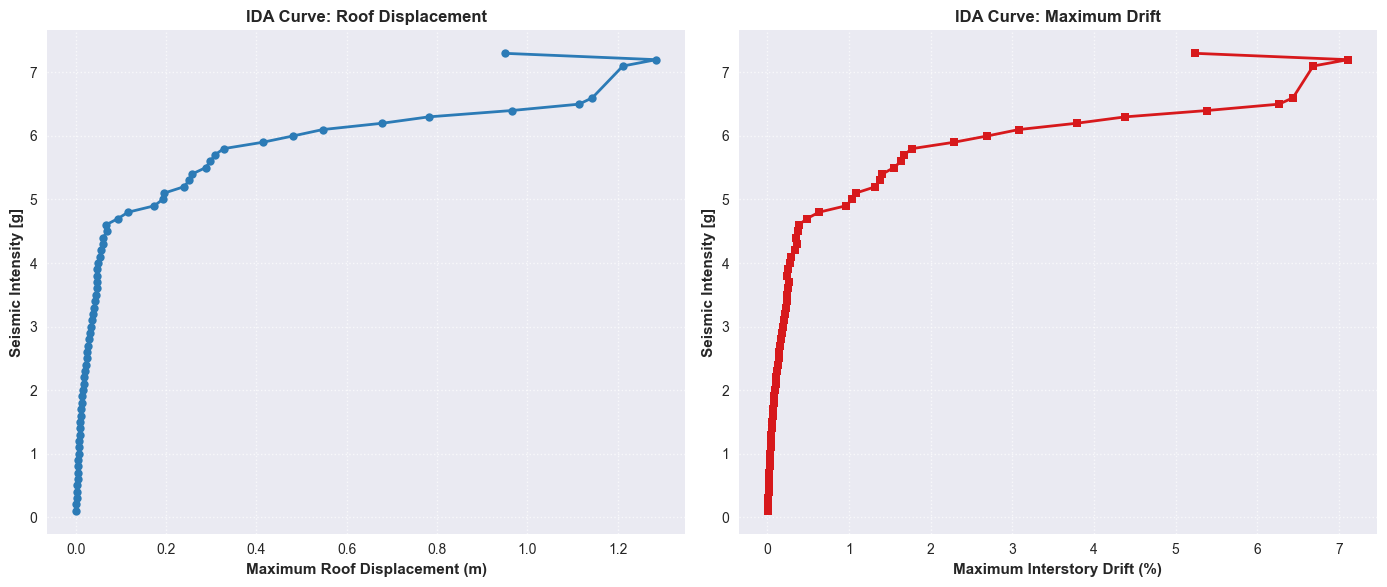

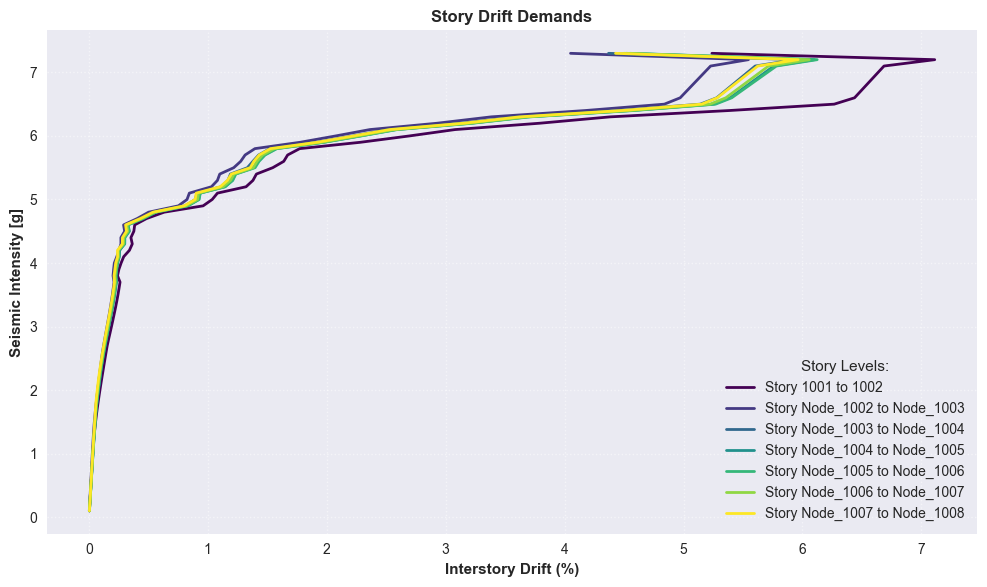


✅ Processing completed successfully!
Results available in:
- Converted CSV files: ./Processed_CSV/
- Results summary: ./Processed_Results/IDA_Results_Summary.csv
- Plots: ./Processed_Results/IDA_Curves.png
- Plots: ./Processed_Results/Story_Drift_Profiles.png


In [49]:
def convert_txt_to_csv():
    """Convert all TXT result files to CSV format with proper headers"""
    Path("Processed_CSV").mkdir(exist_ok=True)
        
    for filename in os.listdir():
        if filename.startswith("Diaphragms_IDA_UX_") and filename.endswith(".txt"):
            try:

                data = pd.read_csv(filename, sep=r'\s+', header=None)
                if data.empty:
                    print(f"⚠️ Empty file skipped: {filename}")
                    continue
                    
                num_nodes = data.shape[1]
                data.columns = [f'Node_{1001+i}' for i in range(num_nodes)]
                
                csv_name = filename.replace('.txt', '.csv')
                data.to_csv(f"Processed_CSV/{csv_name}", index=False, float_format='%.6f')
                print(f"✓ Converted: {filename} → Processed_CSV/{csv_name}")
            except Exception as e:
                print(f"✗ Error converting {filename}: {str(e)}")

def calculate_story_drifts(data, story_height):
    """
    Calculate interstory drifts considering:
    - First story: (Node_1002 - 0) since ground doesn't move
    - Other stories: (Upper_node - Lower_node)
    
    Returns:
        DataFrame with drift percentages for each story
    """
    drifts = pd.DataFrame()
    num_nodes = len(data.columns)
    
    # First story (Node_1002 - 0)
    if num_nodes >= 1:
        drifts['Drift_1001-1002'] = (data['Node_1002'] - 0).abs() / story_height * 100
    
    # Remaining stories
    for i in range(2, num_nodes):
        lower_node = f'Node_{1000+i}'
        upper_node = f'Node_{1001+i}'
        col_name = f'Drift_{lower_node}-{upper_node}'
        drifts[col_name] = (data[upper_node] - data[lower_node]).abs() / story_height * 100
    
    return drifts

def process_ida_results(story_height, output_dir="Processed_Results"):
    """
    Process IDA results and generate:
    - Summary CSV with key metrics
    - Professional quality plots
    """
    Path(output_dir).mkdir(exist_ok=True)
    results = []
    
    for filename in os.listdir("Processed_CSV"):
        if filename.startswith("Diaphragms_IDA_UX_") and filename.endswith(".csv"):
            try:
                # Extract intensity measure from filename
                IM_value = float(filename.split('_')[-1].replace('.csv', ''))
                data = pd.read_csv(f"Processed_CSV/{filename}")
                num_nodes = len(data.columns)
                
                # 1. Calculate roof displacement
                roof_node = data.columns[-1]
                max_disp = data[roof_node].abs().max()
                
                # 2. Calculate story drifts (properly referenced)
                if num_nodes >= 1:
                    drifts = calculate_story_drifts(data, story_height)
                    max_drift = drifts.max().max()
                    story_drifts = {col: drifts[col].max() for col in drifts.columns}
                else:
                    max_drift = np.nan
                    story_drifts = {}
                
                results.append({
                    'IM': IM_value,
                    'MaxRoofDisp': max_disp,
                    'MaxStoryDrift': max_drift,
                    **story_drifts,
                    'SourceFile': filename  # For traceability
                })
                
            except Exception as e:
                print(f"✗ Error processing {filename}: {str(e)}")
    
    # Create sorted results dataframe
    results_df = pd.DataFrame(results).sort_values('IM')
    
    # Save with full precision
    results_df.to_csv(f"{output_dir}/IDA_Results_Summary.csv", 
                     index=False, 
                     float_format='%.6f')
    
    # Generate professional plots
    generate_ida_plots(results_df, output_dir)
    
    return results_df

def generate_ida_plots(df, output_dir):
    """Generate publication-quality IDA plots"""
    plt.style.use('seaborn-v0_8')
    plt.rcParams['figure.figsize'] = [12, 6]
    plt.rcParams['font.size'] = 11
    plt.rcParams['axes.titlesize'] = 12
    plt.rcParams['axes.titleweight'] = 'bold'
    
    if df.empty:
        print("⚠️ No data available for plotting")
        return
    
    # Figure 1: Main IDA Curves
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Roof displacement curve
    ax1.plot(df['MaxRoofDisp'], df['IM'], 'o-', 
            color='#2c7bb6', linewidth=2, markersize=6)
    ax1.set_xlabel('Maximum Roof Displacement (m)', fontweight='bold')
    ax1.set_ylabel('Seismic Intensity [g]', fontweight='bold')
    ax1.set_title('IDA Curve: Roof Displacement', fontweight='bold')
    ax1.grid(True, linestyle=':', alpha=0.7)
    
    # Maximum story drift curve
    ax2.plot(df['MaxStoryDrift'], df['IM'], 's-', 
            color='#d7191c', linewidth=2, markersize=6)
    ax2.set_xlabel('Maximum Interstory Drift (%)', fontweight='bold')
    ax2.set_ylabel('Seismic Intensity [g]', fontweight='bold')
    ax2.set_title('IDA Curve: Maximum Drift', fontweight='bold')
    ax2.grid(True, linestyle=':', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig(f"{output_dir}/IDA_Curves.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Figure 2: Story-by-Story Drifts
    drift_cols = [col for col in df if col.startswith('Drift_')]
    if drift_cols:
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Color palette for stories
        colors = plt.cm.viridis(np.linspace(0, 1, len(drift_cols)))
        
        for col, color in zip(drift_cols, colors):
            story_label = col.replace('Drift_', 'Story ').replace('-', ' to ')
            ax.plot(df[col], df['IM'], '-', 
                   color=color, label=story_label, linewidth=2)
        
        ax.set_xlabel('Interstory Drift (%)', fontweight='bold')
        ax.set_ylabel('Seismic Intensity [g]', fontweight='bold')
        ax.set_title('Story Drift Demands', fontweight='bold')
        ax.legend(title="Story Levels:", framealpha=0.9)
        ax.grid(True, linestyle=':', alpha=0.5)
        
        plt.tight_layout()
        plt.savefig(f"{output_dir}/Story_Drift_Profiles.png", 
                   dpi=300, bbox_inches='tight')
        plt.show()

# Main execution
if __name__ == "__main__":
    print("🔄 Converting TXT results to CSV format...")
    convert_txt_to_csv()
    
    print("\n📊 Processing IDA results...")
    results = process_ida_results(story_height)
    
    print("\n✅ Processing completed successfully!")
    print("Results available in:")
    print(f"- Converted CSV files: ./Processed_CSV/")
    print(f"- Results summary: ./Processed_Results/IDA_Results_Summary.csv")
    print(f"- Plots: ./Processed_Results/IDA_Curves.png")
    print(f"- Plots: ./Processed_Results/Story_Drift_Profiles.png")